Dataset shape: (3651, 67)
Time range: 2015-04-19 00:00:00 to 2025-04-16 00:00:00

Missing values per column:
SOFR        1080
OBFR         317
MICH          12
GS10          12
CPIAUCSL      12
T20YIEM       12
ICSA           6
WALCL          3
DGS6MO         1
DGS1MO         1
dtype: int64

Missing values after filling: 0


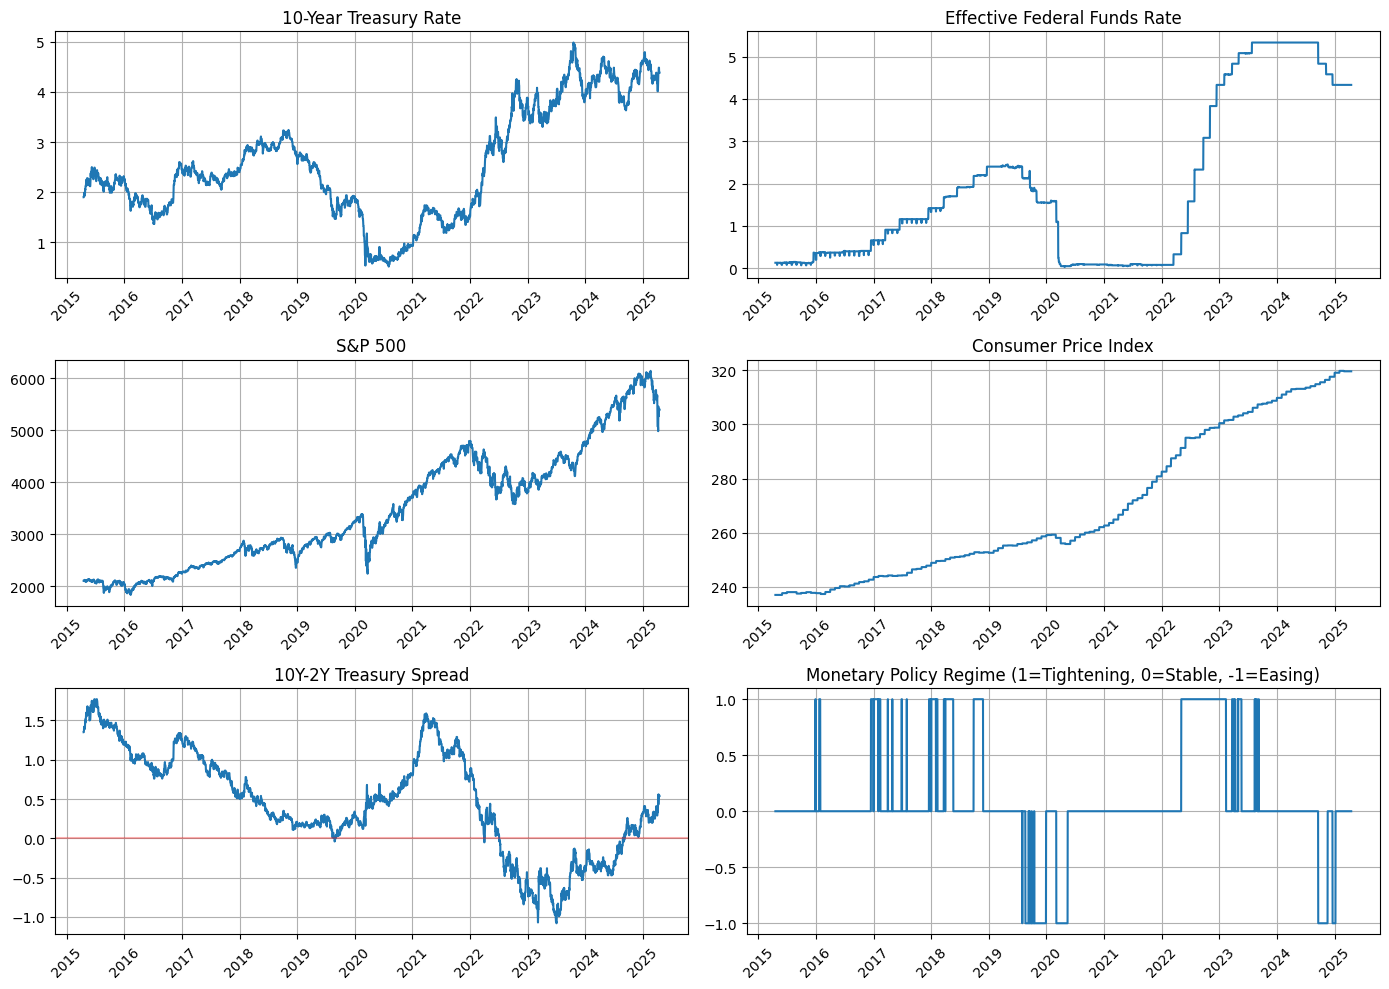

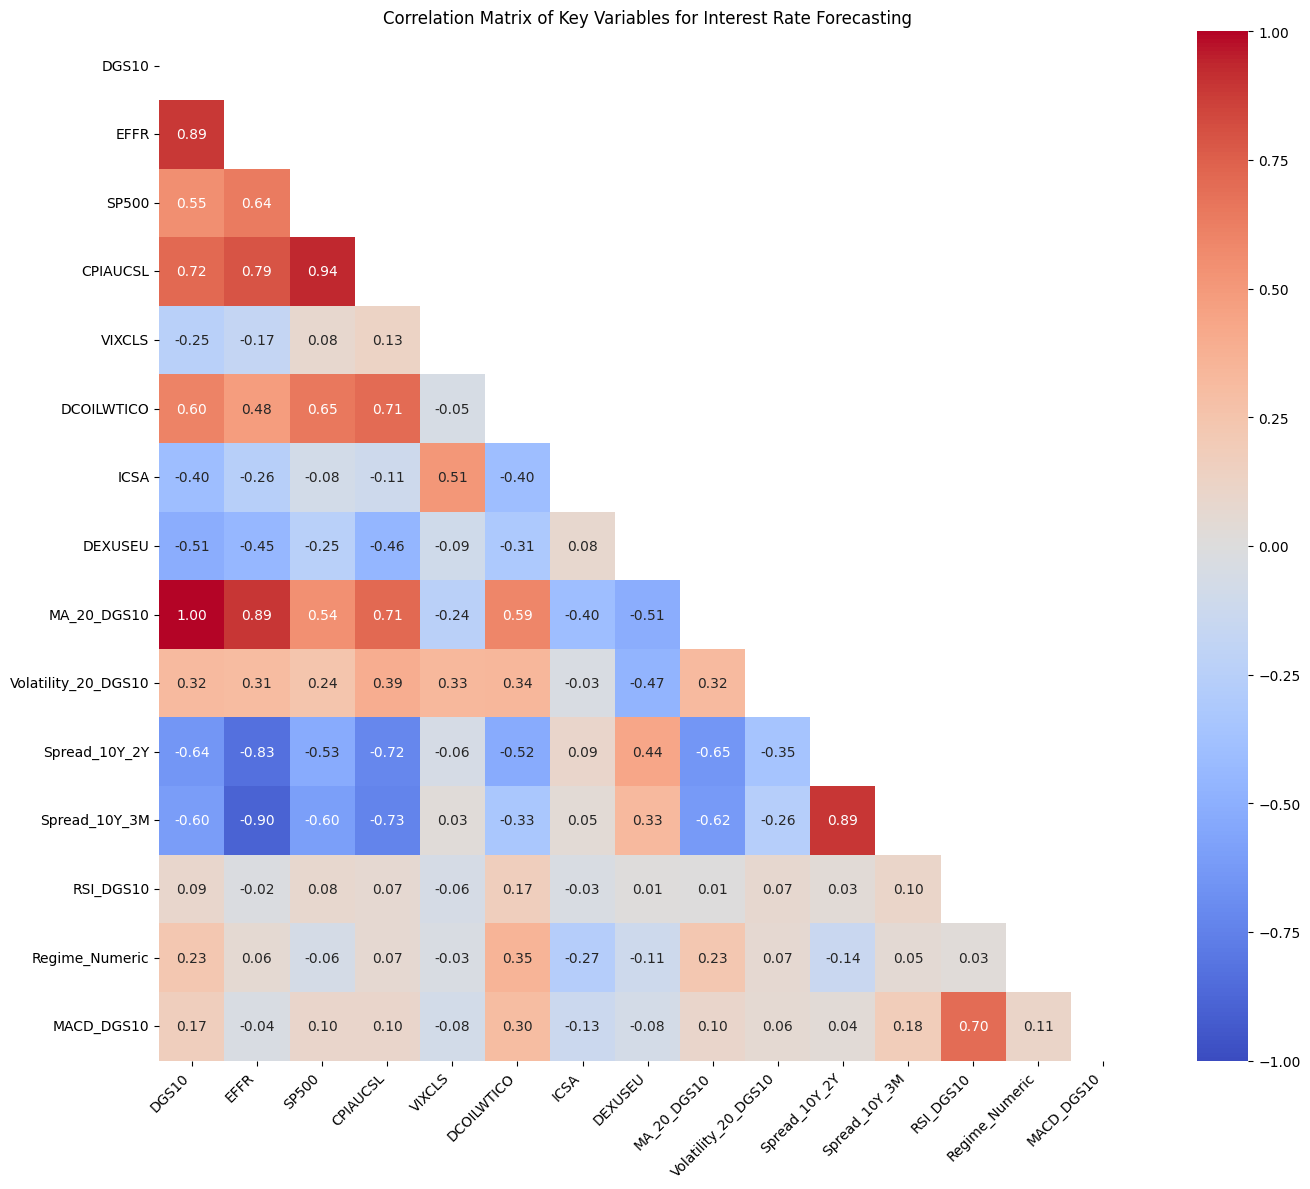


Selected features:
- EFFR
- SP500
- CPIAUCSL
- VIXCLS
- DCOILWTICO
- ICSA
- DEXUSEU
- DGS2
- DGS5
- DGS30
- MA_20_DGS10
- MA_50_DGS10
- Volatility_20_DGS10
- ROC_5_DGS10
- Momentum_20_DGS10
- RSI_DGS10
- MACD_DGS10
- Spread_10Y_2Y
- Spread_10Y_3M
- Spread_30Y_10Y
- Regime_Numeric
- Inversion_Flag
Training set shape: (2579, 10, 22)
Validation set shape: (456, 10, 22)
Test set shape: (606, 10, 22)
Training FNN model...
Epoch [10/200], Train Loss: 0.3295, Val Loss: 0.3535
Train Dir Acc: 31.33%, Val Dir Acc: 34.87%
Epoch [20/200], Train Loss: 0.3257, Val Loss: 0.3536
Train Dir Acc: 30.71%, Val Dir Acc: 34.43%
Epoch [30/200], Train Loss: 0.3230, Val Loss: 0.3747
Train Dir Acc: 30.01%, Val Dir Acc: 30.04%
Early stopping triggered after 39 epochs
Training CNN model...
Epoch [10/200], Train Loss: 0.3228, Val Loss: 0.3501
Train Dir Acc: 30.09%, Val Dir Acc: 30.04%
Epoch [20/200], Train Loss: 0.3266, Val Loss: 0.3961
Train Dir Acc: 30.90%, Val Dir Acc: 36.18%
Epoch [30/200], Train Loss: 0.3229,

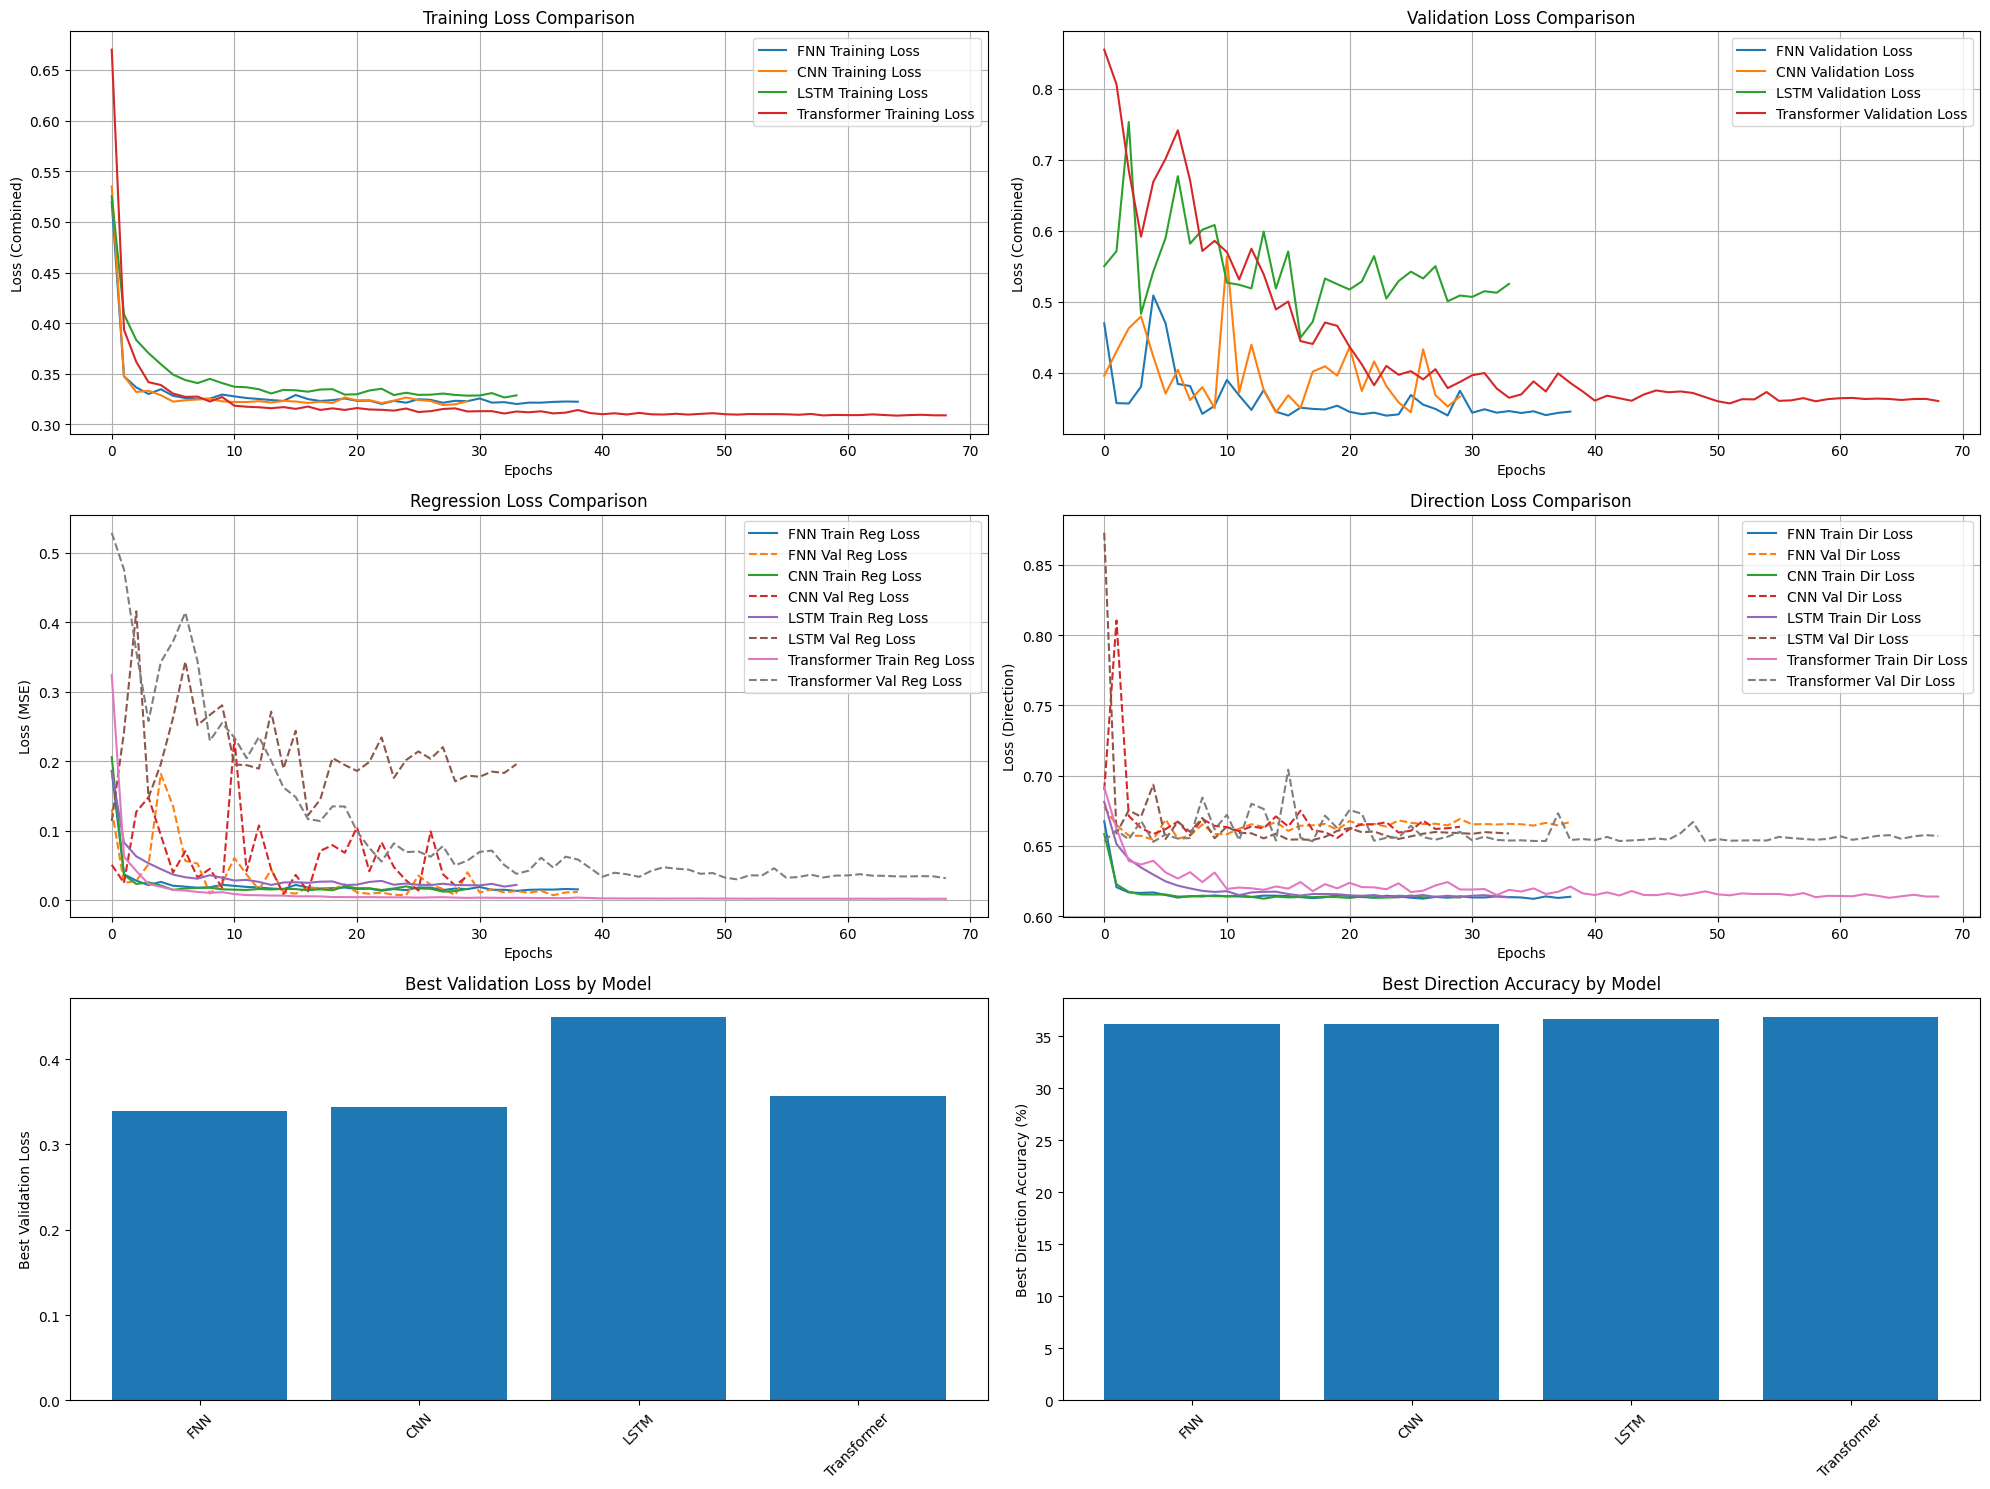


=== Model Performance Comparison ===

Metric                    FNN             CNN             LSTM            Transformer    
-------------------------------------------------------------------------------------
RMSE                      0.0952          0.1513          1.0448          0.3965         
MAE                       0.0740          0.1269          1.0212          0.3834         
MAPE                      1.7144406       2.9648666       23.578808       8.842618       
Direction Accuracy        33.66%          32.84%          31.02%          31.35%         
R-squared                 0.8768802       0.68860686      -13.839241      -1.1373034     


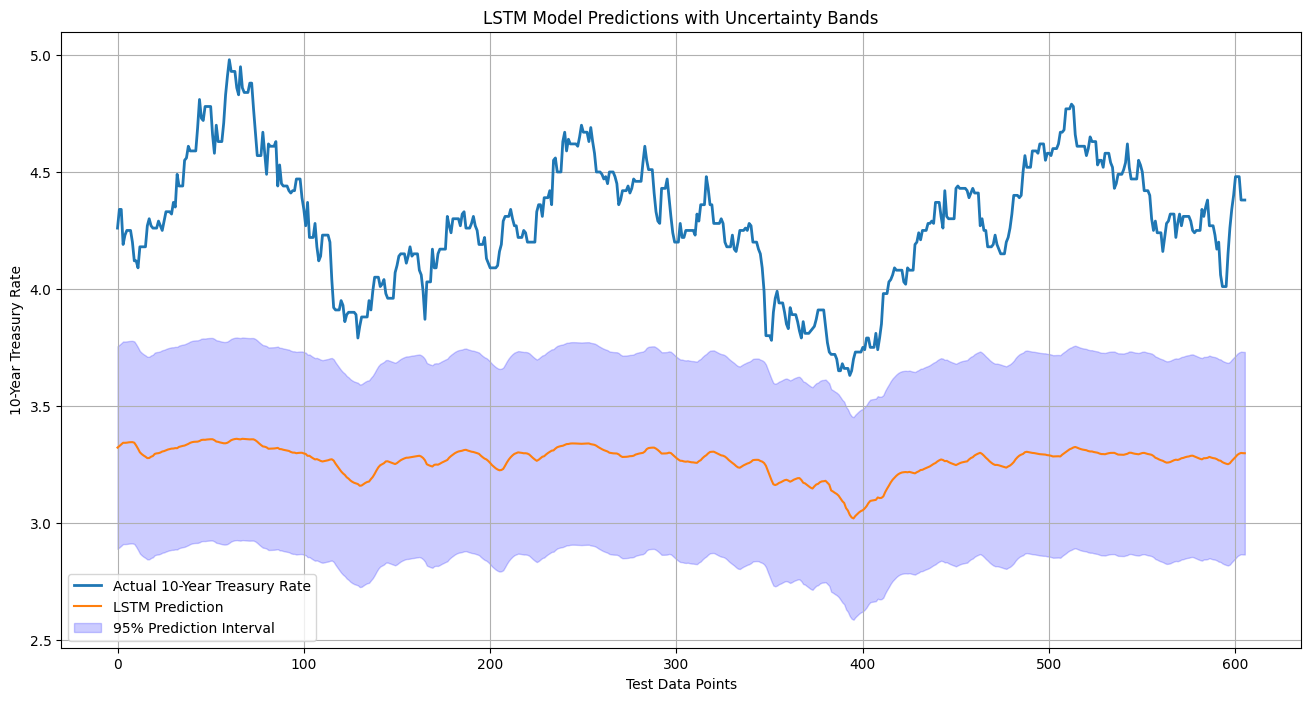

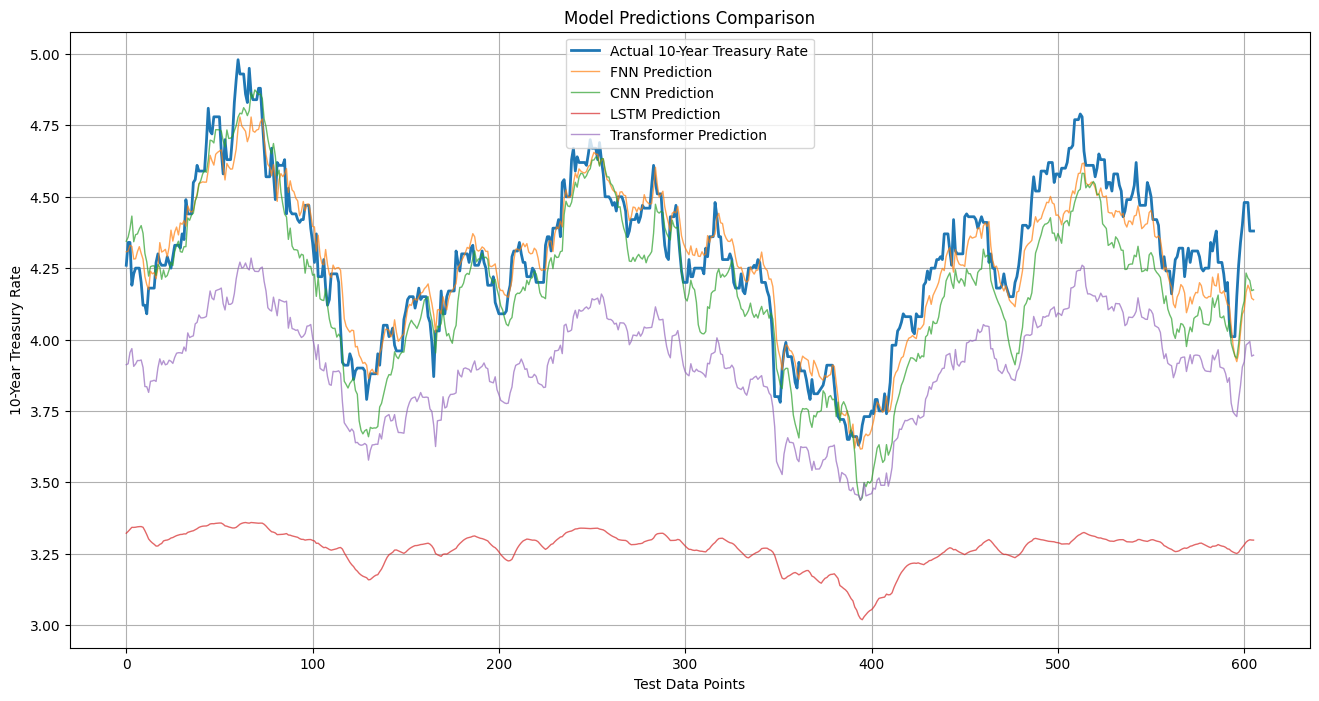

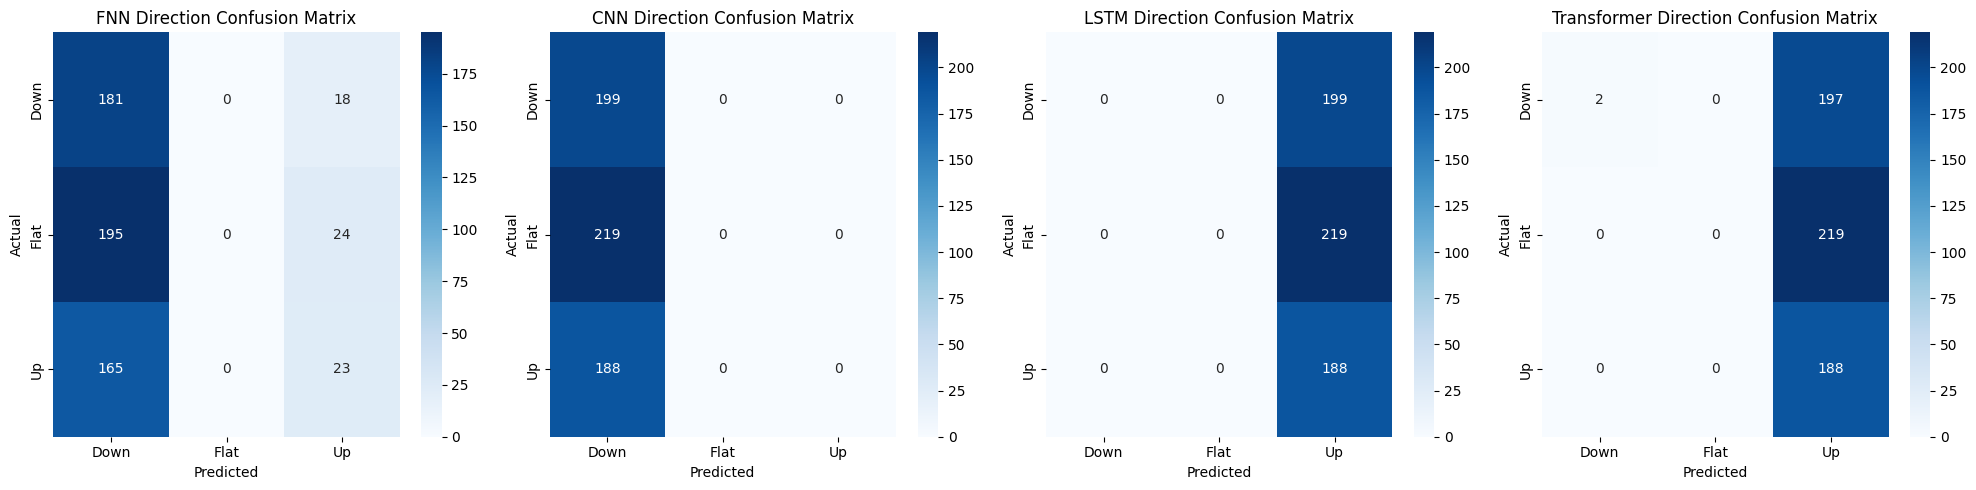

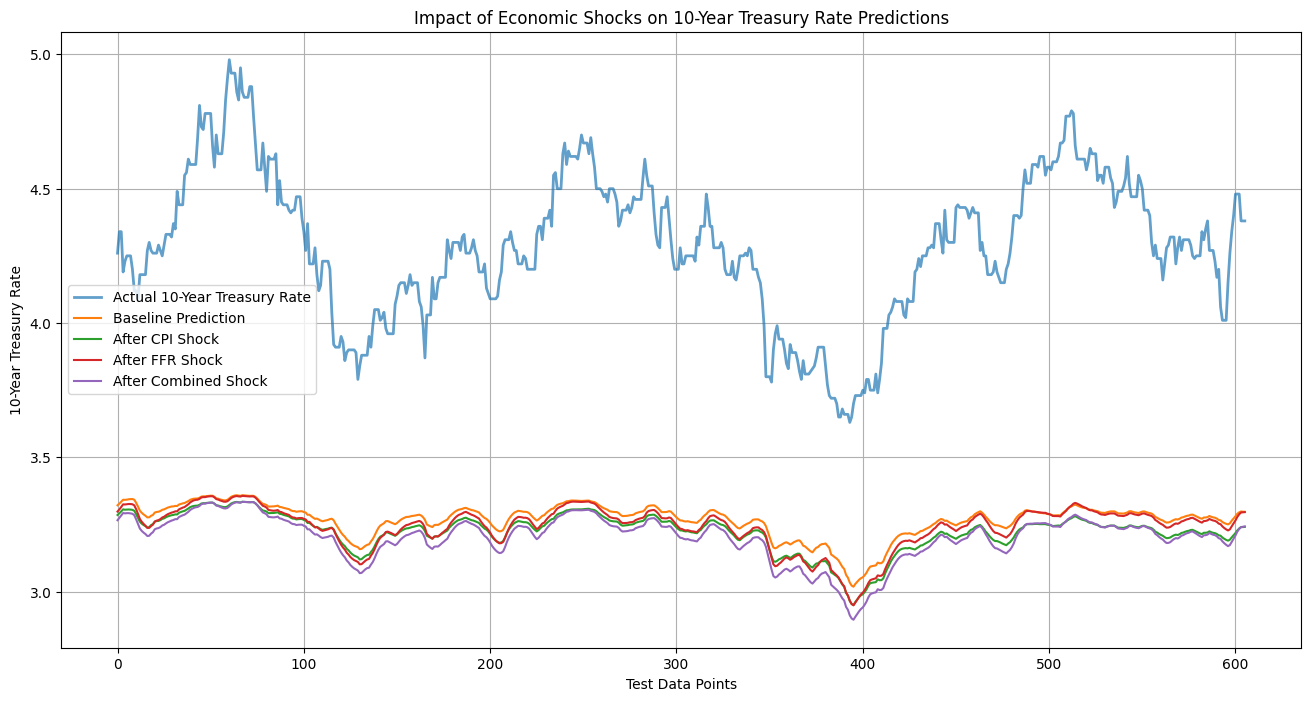


=== Impact of Economic Shocks ===
Average 10-Year Treasury Rate in baseline scenario: 3.27%
Average rate after CPI shock: 3.22% (Change: -1.33%)
Average rate after FFR shock: 3.24% (Change: -0.76%)
Average rate after combined shock: 3.20% (Change: -1.96%)

Maximum point-by-point impacts:
CPI shock: -0.70%
FFR shock: 0.20%
Combined shock: -0.70%


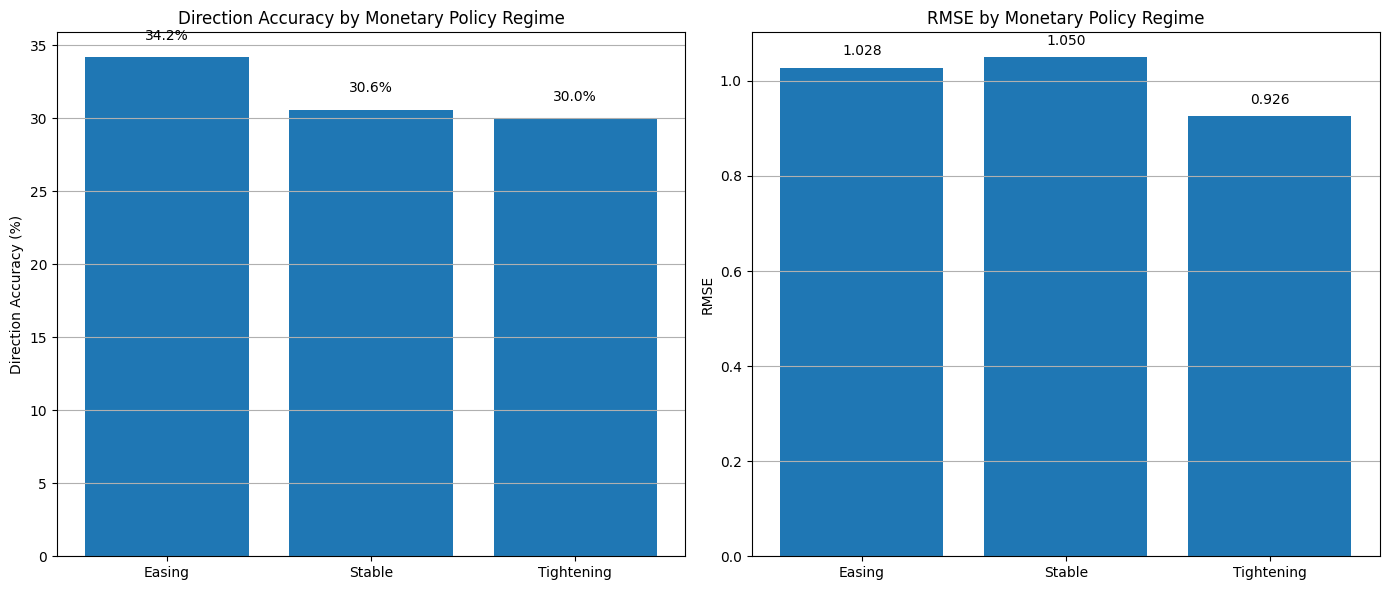

<Figure size 1200x600 with 0 Axes>

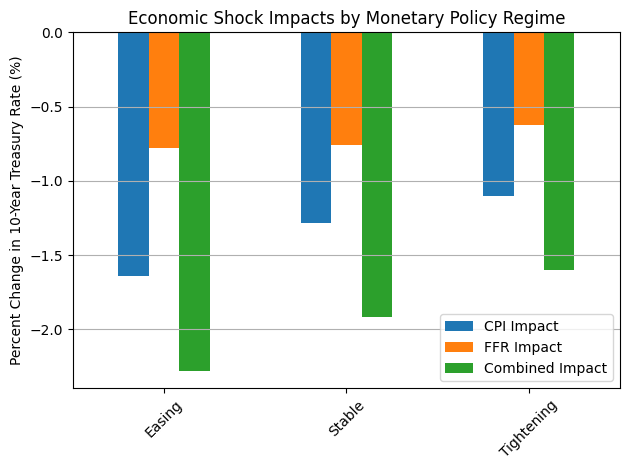

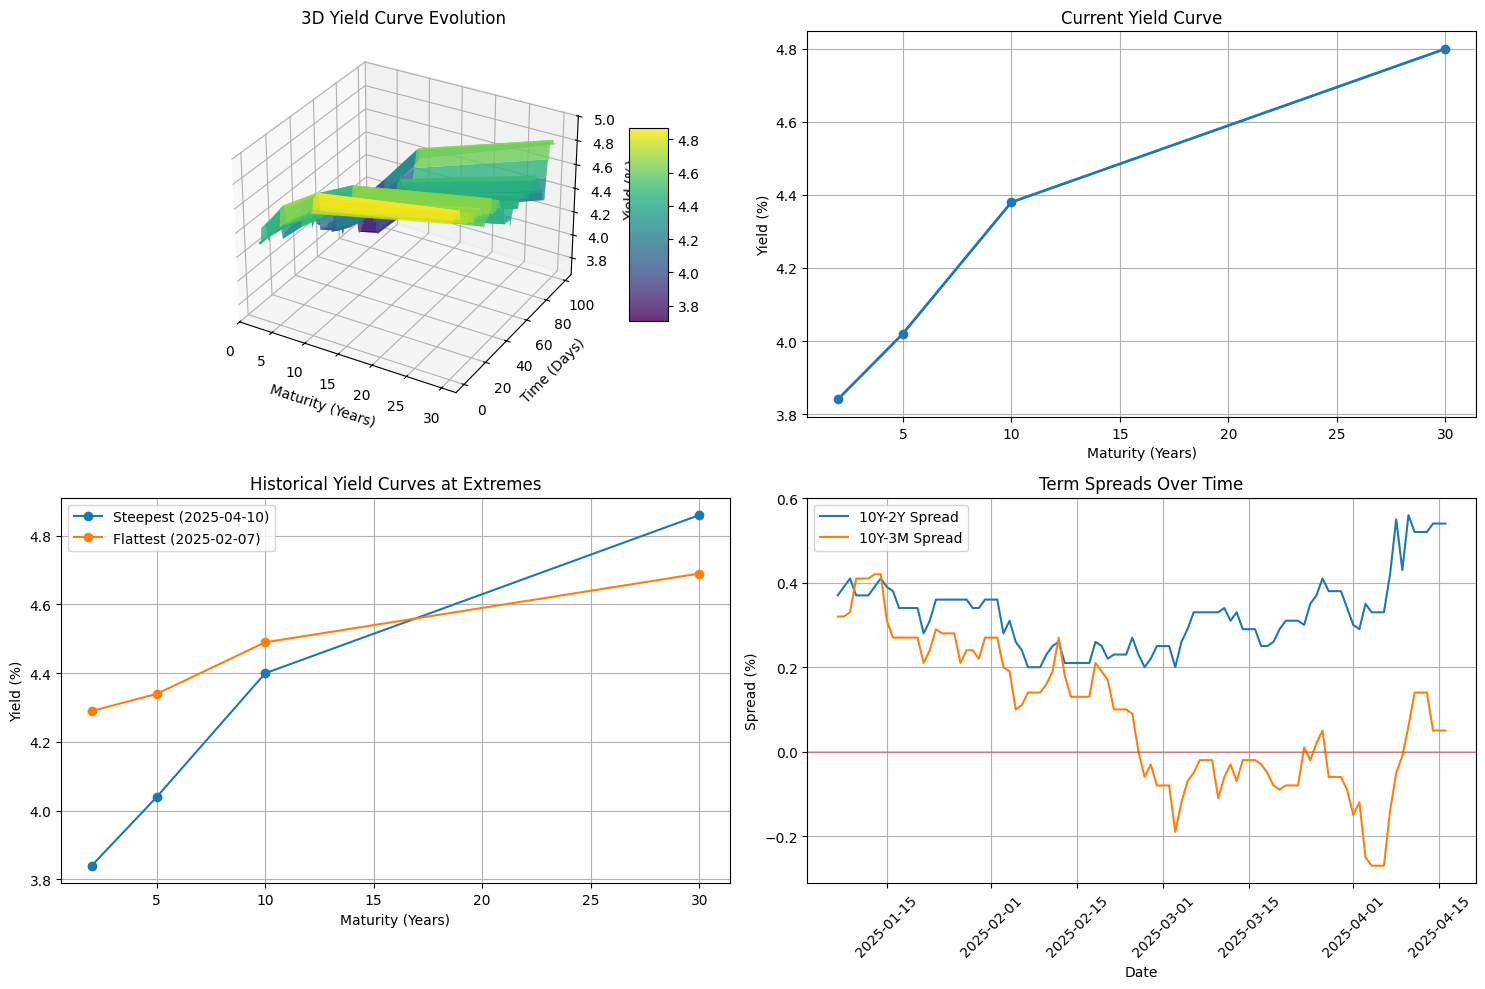

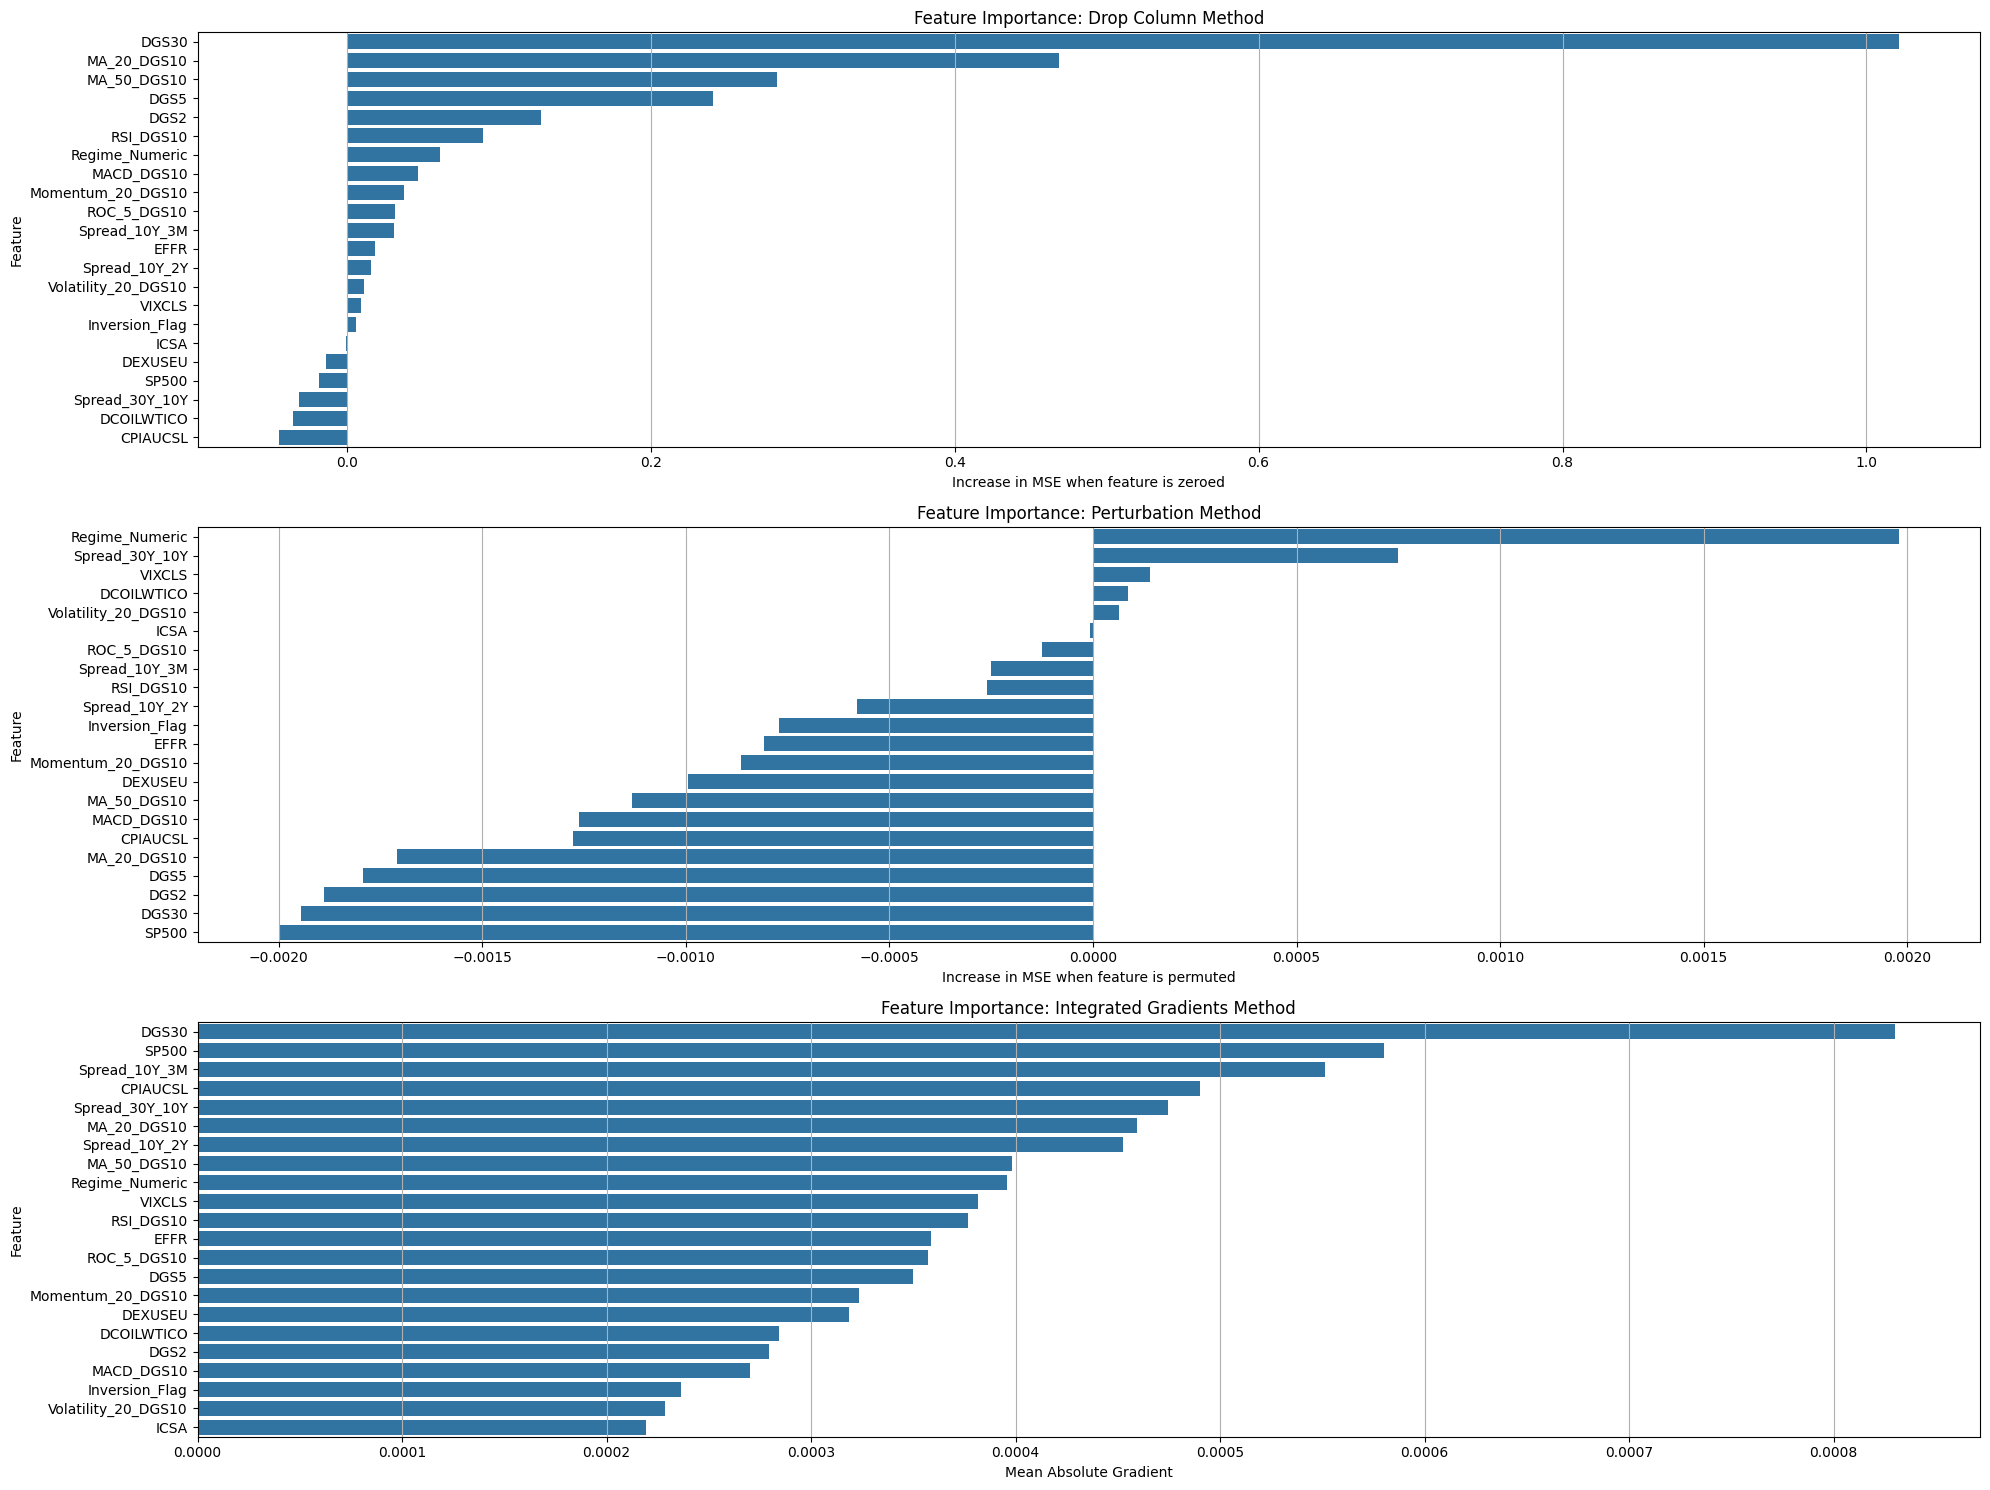

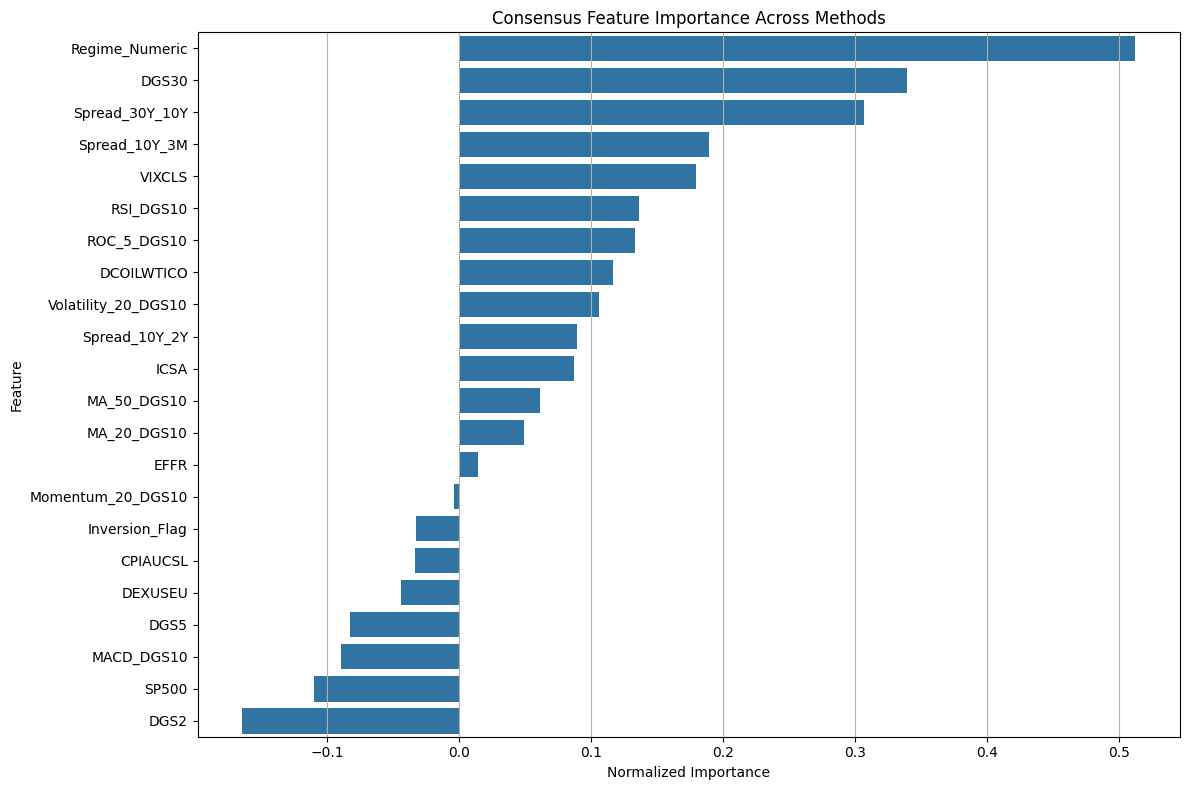


====== Interest Rate Forecasting Model Analysis Summary ======

Target Variable: 10-Year Treasury Rate

Economic Rationale:
The 10-Year Treasury yield is a crucial benchmark for various financial markets,
influencing mortgage rates, corporate borrowing costs, and reflecting market expectations about
future inflation and economic growth.

Model Performance Comparison:

FNN Model:
  RMSE: 0.0952
  Direction Accuracy: 33.66%
  R-squared: 0.8769

CNN Model:
  RMSE: 0.1513
  Direction Accuracy: 32.84%
  R-squared: 0.6886

LSTM Model:
  RMSE: 1.0448
  Direction Accuracy: 31.02%
  R-squared: -13.8392

Transformer Model:
  RMSE: 0.3965
  Direction Accuracy: 31.35%
  R-squared: -1.1373

Top 5 Features by Consensus Importance:
1. 6 (Score: 0.5123)
2. 0 (Score: 0.3391)
3. 19 (Score: 0.3066)
4. 10 (Score: 0.1894)
5. 14 (Score: 0.1796)

Economic Shock Analysis:
CPI Shock Impact: -1.33% increase in 10Y Treasury Rate
FFR Shock Impact: -0.76% increase in 10Y Treasury Rate
Combined Shock Impact: -1.96

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import math
import warnings
from scipy.stats import norm
import statsmodels.api as sm
warnings.filterwarnings('ignore')


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

df = pd.read_csv('fred_combined_10yrs.csv')

# Convert date to datetime and set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Time range: {df.index.min()} to {df.index.max()}")
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Fill missing values with forward fill then backward fill
df = df.fillna(method='ffill').fillna(method='bfill')
print("\nMissing values after filling:", df.isna().sum().sum())

# Enhanced feature engineering for interest rates
def add_enhanced_features(df, target_rate='DGS10'):
    """Add comprehensive features for interest rate forecasting."""
    df_processed = df.copy()

    # Technical indicators for target variable
    # Moving averages at different timeframes
    for window in [5, 20, 50, 100]:
        df_processed[f'MA_{window}_{target_rate}'] = df_processed[target_rate].rolling(window=window).mean()

    # Rate of change at multiple timeframes
    for window in [1, 5, 10, 20]:
        df_processed[f'ROC_{window}_{target_rate}'] = df_processed[target_rate].pct_change(periods=window)

    # Volatility measures
    for window in [10, 20, 50]:
        df_processed[f'Volatility_{window}_{target_rate}'] = df_processed[target_rate].rolling(window=window).std()

    # Momentum indicators
    for window in [5, 10, 20]:
        df_processed[f'Momentum_{window}_{target_rate}'] = df_processed[target_rate] - df_processed[target_rate].shift(window)

    # Rate differentials (term spreads)
    if 'DGS2' in df.columns and target_rate in df.columns:
        df_processed['Spread_10Y_2Y'] = df_processed[target_rate] - df_processed['DGS2']

    if 'DGS3MO' in df.columns and target_rate in df.columns:
        df_processed['Spread_10Y_3M'] = df_processed[target_rate] - df_processed['DGS3MO']

    if 'DGS30' in df.columns and target_rate in df.columns:
        df_processed['Spread_30Y_10Y'] = df_processed['DGS30'] - df_processed[target_rate]

    # Technical analysis indicators
    # RSI (Relative Strength Index)
    delta = df_processed[target_rate].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_processed[f'RSI_{target_rate}'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    middle_band = df_processed[target_rate].rolling(window=20).mean()
    std_dev = df_processed[target_rate].rolling(window=20).std()
    df_processed[f'BB_Upper_{target_rate}'] = middle_band + (std_dev * 2)
    df_processed[f'BB_Lower_{target_rate}'] = middle_band - (std_dev * 2)
    df_processed[f'BB_Width_{target_rate}'] = (df_processed[f'BB_Upper_{target_rate}'] -
                                             df_processed[f'BB_Lower_{target_rate}']) / middle_band

    # Moving Average Convergence Divergence (MACD)
    ema12 = df_processed[target_rate].ewm(span=12, adjust=False).mean()
    ema26 = df_processed[target_rate].ewm(span=26, adjust=False).mean()
    df_processed[f'MACD_{target_rate}'] = ema12 - ema26
    df_processed[f'MACD_Signal_{target_rate}'] = df_processed[f'MACD_{target_rate}'].ewm(span=9, adjust=False).mean()
    df_processed[f'MACD_Hist_{target_rate}'] = df_processed[f'MACD_{target_rate}'] - df_processed[f'MACD_Signal_{target_rate}']

    # Cross-asset relationships
    # Inflation expectations proxy (if available)
    if 'T10YIE' in df.columns:
        df_processed['Real_Rate'] = df_processed[target_rate] - df_processed['T10YIE']

    # Equity risk premium proxy
    if 'SP500' in df.columns:
        # Use S&P 500 earnings yield as proxy for equity premium
        df_processed['SPX_Rate_Diff'] = df_processed['SP500'].pct_change(periods=252).rolling(window=252).mean() - df_processed[target_rate]/100

    # VIX and rate interactions
    if 'VIXCLS' in df.columns:
        df_processed['VIX_Rate_Ratio'] = df_processed['VIXCLS'] / df_processed[target_rate]

    # Interest rate and inflation interaction
    if 'CPIAUCSL' in df.columns:
        df_processed['CPI_YoY'] = df_processed['CPIAUCSL'].pct_change(periods=12) * 100
        df_processed['Real_Rate_CPI'] = df_processed[target_rate] - df_processed['CPI_YoY']

    # Regime indicators
    # Identify monetary policy regime
    if 'EFFR' in df.columns:
        # Calculate 3-month change in Fed Funds Rate
        df_processed['EFFR_3M_Change'] = df_processed['EFFR'].diff(60)

        # Regime classifier
        conditions = [
            (df_processed['EFFR_3M_Change'] > 0.25),  # Tightening
            (df_processed['EFFR_3M_Change'] < -0.25),  # Easing
            (True)
        ]
        choices = ['Tightening', 'Easing', 'Stable']
        df_processed['Monetary_Regime'] = np.select(conditions, choices, default='Stable')

        # Numeric encoding of regime for model input
        regime_map = {'Tightening': 1, 'Stable': 0, 'Easing': -1}
        df_processed['Regime_Numeric'] = df_processed['Monetary_Regime'].map(regime_map)

    # Yield curve inversion indicator
    if 'Spread_10Y_2Y' in df_processed.columns:
        df_processed['Inversion_Flag'] = (df_processed['Spread_10Y_2Y'] < 0).astype(int)

    # Lagged values of target
    for lag in [1, 2, 3, 5, 10, 21]:
        df_processed[f'{target_rate}_Lag{lag}'] = df_processed[target_rate].shift(lag)

    # Lagged changes (derivatives)
    for lag in [1, 5, 10]:
        df_processed[f'{target_rate}_Change{lag}'] = df_processed[target_rate].diff(lag)

    # Direction indicators (for classification)
    df_processed[f'{target_rate}_Direction'] = np.sign(df_processed[target_rate].diff()).fillna(0)

    # Fill any new NaN values created by the calculations
    return df_processed.fillna(method='ffill').fillna(method='bfill')

# Specify target variable - 10-Year Treasury Yield
target_variable = 'DGS10'

# Apply enhanced feature engineering
df_enhanced = add_enhanced_features(df, target_variable)

# Plot key variables
plt.figure(figsize=(14, 10))

# Plot Target: 10-Year Treasury Rate
plt.subplot(3, 2, 1)
plt.plot(df.index, df[target_variable])
plt.title('10-Year Treasury Rate')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Federal Funds Rate
plt.subplot(3, 2, 2)
plt.plot(df.index, df['EFFR'])
plt.title('Effective Federal Funds Rate')
plt.xticks(rotation=45)
plt.grid(True)

# Plot S&P 500
plt.subplot(3, 2, 3)
plt.plot(df.index, df['SP500'])
plt.title('S&P 500')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Consumer Price Index
plt.subplot(3, 2, 4)
plt.plot(df.index, df['CPIAUCSL'])
plt.title('Consumer Price Index')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Term Spread
if 'Spread_10Y_2Y' in df_enhanced.columns:
    plt.subplot(3, 2, 5)
    plt.plot(df_enhanced.index, df_enhanced['Spread_10Y_2Y'])
    plt.title('10Y-2Y Treasury Spread')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45)
    plt.grid(True)

# Plot Regime Indicator
if 'Regime_Numeric' in df_enhanced.columns:
    plt.subplot(3, 2, 6)
    plt.plot(df_enhanced.index, df_enhanced['Regime_Numeric'])
    plt.title('Monetary Policy Regime (1=Tightening, 0=Stable, -1=Easing)')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.savefig('key_variables_plot_rates_enhanced.png')
plt.show()

# Create a correlation heatmap with key variables
# Select a subset of important variables to keep visualization manageable
key_vars = [
    target_variable, 'EFFR', 'SP500', 'CPIAUCSL', 'VIXCLS', 'DCOILWTICO',
    'ICSA', 'DEXUSEU'
]

# Add derived features
derived_features = [
    f'MA_20_{target_variable}', f'Volatility_20_{target_variable}',
    'Spread_10Y_2Y', 'Spread_10Y_3M', f'RSI_{target_variable}',
    'Regime_Numeric', f'MACD_{target_variable}'
]

for feat in derived_features:
    if feat in df_enhanced.columns:
        key_vars.append(feat)

correlation = df_enhanced[key_vars].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Key Variables for Interest Rate Forecasting')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap_rates_enhanced.png')
plt.show()

# 2. Feature Selection and Data Processing
# Focus on recent data for more relevant patterns
cutoff_date = pd.to_datetime('2015-01-01')
df_recent = df_enhanced[df_enhanced.index >= cutoff_date].copy()

# Create a list of base economic features (not derived from target)
base_economic_features = [
    'EFFR',         # Federal Funds Rate (monetary policy)
    'SP500',        # S&P 500 (equity market performance)
    'CPIAUCSL',     # Consumer Price Index (inflation)
    'VIXCLS',       # Volatility Index (market uncertainty)
    'DCOILWTICO',   # Oil Prices (inflation expectations)
    'ICSA',         # Initial jobless claims (labor market health)
    'DEXUSEU',      # USD/EUR exchange rate (international conditions)
]

# Add available term structure components
term_structure = [col for col in df_recent.columns if col.startswith('DGS') and col != target_variable]
selected_term = ['DGS2', 'DGS5', 'DGS30'] if all(term in df_recent.columns for term in ['DGS2', 'DGS5', 'DGS30']) else []

# Add technical indicators
tech_indicators = [
    f'MA_20_{target_variable}',
    f'MA_50_{target_variable}',
    f'Volatility_20_{target_variable}',
    f'ROC_5_{target_variable}',
    f'Momentum_20_{target_variable}',
    f'RSI_{target_variable}',
    f'MACD_{target_variable}'
]

# Add available spread measures
spread_measures = [col for col in df_recent.columns if col.startswith('Spread_')]

# Add regime indicators
regime_indicators = ['Regime_Numeric', 'Inversion_Flag'] if all(col in df_recent.columns for col in ['Regime_Numeric', 'Inversion_Flag']) else []

# Combine all feature groups
all_features = base_economic_features + selected_term + tech_indicators + spread_measures + regime_indicators

# Ensure all features exist in the dataset
selected_features = [f for f in all_features if f in df_recent.columns]

print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")

# Create target variable for regression (next day value)
X_data = df_recent[selected_features]
y_data = df_recent[target_variable]

# Also create a target for directional prediction (classification)
y_direction = np.sign(df_recent[target_variable].diff().shift(-1)).fillna(0)

# Normalize data
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_data)

# Use StandardScaler for target
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_data.values.reshape(-1, 1))

# Create sequences for LSTM with enhanced configurations
def create_sequences(X, y, y_dir=None, seq_length=10):
    """Create sequences of data for LSTM input with optional direction target."""
    X_seq, y_seq = [], []
    y_dir_seq = [] if y_dir is not None else None

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
        if y_dir is not None:
            y_dir_seq.append(y_dir[i + seq_length])

    if y_dir is not None:
        return np.array(X_seq), np.array(y_seq), np.array(y_dir_seq)
    else:
        return np.array(X_seq), np.array(y_seq)

# Sequence length (window size) - 10 trading days (2 weeks)
seq_length = 10
X_seq, y_seq, y_dir_seq = create_sequences(X_scaled, y_scaled, y_direction.values, seq_length)

# Create a more robust validation scheme with time series split
tscv = TimeSeriesSplit(n_splits=5)
# Get the last split for final testing
train_indices = []
val_indices = []
test_indices = []

for train_idx, test_idx in tscv.split(X_seq):
    train_indices = train_idx
    test_indices = test_idx

# Further split the training data to get a validation set
train_size = int(len(train_indices) * 0.85)
train_indices, val_indices = train_indices[:train_size], train_indices[train_size:]

# Apply indices to get train, validation, and test sets
X_train, y_train, y_dir_train = X_seq[train_indices], y_seq[train_indices], y_dir_seq[train_indices]
X_val, y_val, y_dir_val = X_seq[val_indices], y_seq[val_indices], y_dir_seq[val_indices]
X_test, y_test, y_dir_test = X_seq[test_indices], y_seq[test_indices], y_dir_seq[test_indices]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
y_dir_train_tensor = torch.FloatTensor(y_dir_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
y_dir_val_tensor = torch.FloatTensor(y_dir_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
y_dir_test_tensor = torch.FloatTensor(y_dir_test)

# Create enhanced dataset class for multi-task learning
class EnhancedTimeSeriesDataset(Dataset):
    """Dataset for combined regression and classification tasks."""
    def __init__(self, X, y_reg, y_dir=None):
        self.X = X
        self.y_reg = y_reg
        self.y_dir = y_dir

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y_dir is not None:
            return self.X[idx], self.y_reg[idx], self.y_dir[idx]
        else:
            return self.X[idx], self.y_reg[idx]

# Create data loaders
batch_size = 32
train_dataset = EnhancedTimeSeriesDataset(X_train_tensor, y_train_tensor, y_dir_train_tensor)
val_dataset = EnhancedTimeSeriesDataset(X_val_tensor, y_val_tensor, y_dir_val_tensor)
test_dataset = EnhancedTimeSeriesDataset(X_test_tensor, y_test_tensor, y_dir_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Enhanced Model Architectures

# 3.1 Enhanced Feed Forward Neural Network with Dual Output
class EnhancedFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.3):
        super(EnhancedFNN, self).__init__()

        # Flatten the input
        self.flatten = nn.Flatten()

        # Create layers dynamically based on hidden_dims list
        layers = []
        prev_dim = input_dim * seq_length  # Flattened input dimension

        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.BatchNorm1d(hidden_dim))

            if i < len(hidden_dims) - 1:  # No dropout on the last hidden layer
                layers.append(nn.Dropout(dropout))

            prev_dim = hidden_dim

        self.shared_layers = nn.Sequential(*layers)

        # Output layers for regression and classification tasks
        self.regression_head = nn.Linear(hidden_dims[-1], 1)
        self.direction_head = nn.Linear(hidden_dims[-1], 1)

    def forward(self, x):
        x = self.flatten(x)
        shared_features = self.shared_layers(x)

        # Regression output
        reg_output = self.regression_head(shared_features)

        # Direction prediction output
        dir_output = self.direction_head(shared_features)

        return reg_output, torch.tanh(dir_output)  # tanh for direction (-1, 0, 1)

# 3.2 Enhanced CNN with Attention Mechanism
# The error is in the EnhancedCNN class, specifically in the forward method where the tensors
# from different convolutions have mismatched dimensions (size 11 vs size 10)

# Here's the fixed version of the CNN class:
class EnhancedCNN(nn.Module):
    def __init__(self, input_channels, seq_length, num_filters=64, kernel_sizes=[2, 3, 5], dropout=0.3):
        super(EnhancedCNN, self).__init__()

        # Modified to ensure consistent output sizes
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for k in kernel_sizes:
            # Calculate padding to maintain sequence length
            # Using same padding = (kernel_size - 1) // 2
            padding = (k - 1) // 2

            self.convs.append(nn.Conv1d(
                in_channels=input_channels,
                out_channels=num_filters,
                kernel_size=k,
                padding=padding
            ))

            self.batch_norms.append(nn.BatchNorm1d(num_filters))

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(num_filters * len(kernel_sizes), seq_length),
            nn.Softmax(dim=1)
        )

        # Calculate output size after convolutions
        self.conv_output_size = num_filters * len(kernel_sizes)

        # Fully connected layers
        self.fc_shared = nn.Sequential(
            nn.Linear(self.conv_output_size, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64)
        )

        # Output heads
        self.regression_head = nn.Linear(64, 1)
        self.direction_head = nn.Linear(64, 1)

    def forward(self, x):
        # x shape: [batch, seq_len, features]
        # Conv1d expects: [batch, features, seq_len]
        x = x.permute(0, 2, 1)

        # Apply convolutions and collect results
        conv_results = []
        for i, conv in enumerate(self.convs):
            # Apply convolution with batch normalization
            feature_map = F.leaky_relu(self.batch_norms[i](conv(x)), 0.1)

            # Apply global max pooling to each feature map
            pooled = F.adaptive_max_pool1d(feature_map, 1).squeeze(2)
            conv_results.append(pooled)

        # Concatenate the pooled results
        combined_features = torch.cat(conv_results, dim=1)

        # Shared fully connected layers
        shared_features = self.fc_shared(combined_features)

        # Output heads
        reg_output = self.regression_head(shared_features)
        dir_output = self.direction_head(shared_features)

        return reg_output, torch.tanh(dir_output)

# 3.3 Enhanced LSTM with Attention and Regime-Conditioning
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.3):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)

        # Second LSTM layer with residual connection
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, 1, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim*2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim*2)

        # Multi-head self-attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_dim*2, num_heads=4, dropout=dropout)

        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout3 = nn.Dropout(dropout)

        # Output heads
        self.regression_head = nn.Linear(hidden_dim, 1)
        self.direction_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # First bidirectional LSTM layer
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        lstm1_out = self.layer_norm1(lstm1_out)

        # Second bidirectional LSTM layer with residual connection
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)
        lstm2_out = self.layer_norm2(lstm2_out + lstm1_out)  # Residual connection

        # Self-attention (transpose for attention input: [seq_len, batch, features])
        lstm_out_transposed = lstm2_out.transpose(0, 1)
        attn_output, _ = self.self_attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)
        attn_output = attn_output.transpose(0, 1)  # Back to [batch, seq, features]

        # Get context vector (focus on the last time step with attention applied)
        context = attn_output[:, -1, :]

        # Fully connected layer
        fc_out = self.relu(self.bn1(self.fc1(context)))
        fc_out = self.dropout3(fc_out)

        # Output heads
        reg_output = self.regression_head(fc_out)
        dir_output = self.direction_head(fc_out)

        return reg_output, torch.tanh(dir_output)

# 3.4 Transformer Model for Time Series
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch, seq, features]
        # Expected: [seq, batch, features]
        x = x.transpose(0, 1)
        x = x + self.pe[:x.size(0), :]
        return x.transpose(0, 1)  # Return to [batch, seq, features]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.3):
        super(TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output heads
        self.regression_head = nn.Linear(d_model, 1)
        self.direction_head = nn.Linear(d_model, 1)

    def forward(self, src):
        # Project input to transformer dimension
        src = self.input_projection(src)

        # Add positional encoding
        src = self.pos_encoder(src)

        # Apply transformer encoder (expects [batch, seq, features])
        output = self.transformer_encoder(src)

        # Get the last time step for prediction
        final_output = output[:, -1, :]

        # Output heads
        reg_output = self.regression_head(final_output)
        dir_output = self.direction_head(final_output)

        return reg_output, torch.tanh(dir_output)

# Initialize models with improved architectures
input_dim = len(selected_features)  # Number of features
hidden_dim = 128                    # Hidden dimension
num_layers = 2                      # Number of layers
dropout = 0.3                       # Dropout rate

# Enhanced FNN Model
fnn_model = EnhancedFNN(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=dropout
)

# Enhanced CNN Model
cnn_model = EnhancedCNN(
    input_channels=input_dim,
    seq_length=seq_length,
    num_filters=64,
    kernel_sizes=[2, 3, 5],
    dropout=dropout
)

# Enhanced LSTM Model
lstm_model = EnhancedLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Transformer Model
transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=128,
    nhead=8,
    num_layers=2,
    dim_feedforward=512,
    dropout=dropout
)

# Custom Loss Function for Multi-Task Learning
class CombinedLoss(nn.Module):
    """Combined loss function for regression and direction prediction."""
    def __init__(self, reg_weight=1.0, dir_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.reg_weight = reg_weight
        self.dir_weight = dir_weight
        self.reg_criterion = nn.MSELoss()
        self.dir_criterion = nn.MSELoss()  # Mean squared error for direction (-1, 0, 1)

    def forward(self, reg_pred, dir_pred, reg_target, dir_target):
        reg_loss = self.reg_criterion(reg_pred, reg_target)
        dir_loss = self.dir_criterion(dir_pred, dir_target)
        return self.reg_weight * reg_loss + self.dir_weight * dir_loss, reg_loss, dir_loss

# Define loss functions and optimizers
criterion = CombinedLoss(reg_weight=1.0, dir_weight=0.5)

# Optimizers with learning rate schedulers
fnn_optimizer = optim.Adam(fnn_model.parameters(), lr=0.001, weight_decay=1e-5)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0005, weight_decay=1e-5)
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate schedulers
fnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(fnn_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
lstm_scheduler = optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
transformer_scheduler = optim.lr_scheduler.ReduceLROnPlateau(transformer_optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Enhanced Training Loop with Regime-Aware Training
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=100, patience=15):
    """Train the model with regime-aware sampling and early stopping."""
    train_losses = []
    val_losses = []
    train_reg_losses = []
    train_dir_losses = []
    val_reg_losses = []
    val_dir_losses = []

    best_val_loss = float('inf')
    best_val_dir_acc = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_reg_loss = 0
        train_dir_loss = 0
        train_dir_correct = 0
        train_total = 0

        for X_batch, y_reg_batch, y_dir_batch in train_loader:
            # Forward pass
            reg_outputs, dir_outputs = model(X_batch)

            # Calculate loss
            loss, reg_loss, dir_loss = criterion(reg_outputs, dir_outputs, y_reg_batch, y_dir_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            train_reg_loss += reg_loss.item()
            train_dir_loss += dir_loss.item()

            # Calculate direction accuracy
            predicted_directions = torch.sign(dir_outputs).squeeze()
            true_directions = y_dir_batch.squeeze()
            train_dir_correct += (predicted_directions == true_directions).sum().item()
            train_total += true_directions.size(0)

        # Calculate average training metrics
        train_loss = train_loss / len(train_loader)
        train_reg_loss = train_reg_loss / len(train_loader)
        train_dir_loss = train_dir_loss / len(train_loader)
        train_dir_acc = 100 * train_dir_correct / train_total if train_total > 0 else 0

        train_losses.append(train_loss)
        train_reg_losses.append(train_reg_loss)
        train_dir_losses.append(train_dir_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_reg_loss = 0
        val_dir_loss = 0
        val_dir_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_reg_batch, y_dir_batch in val_loader:
                # Forward pass
                reg_outputs, dir_outputs = model(X_batch)

                # Calculate loss
                loss, reg_loss, dir_loss = criterion(reg_outputs, dir_outputs, y_reg_batch, y_dir_batch)

                # Track metrics
                val_loss += loss.item()
                val_reg_loss += reg_loss.item()
                val_dir_loss += dir_loss.item()

                # Calculate direction accuracy
                predicted_directions = torch.sign(dir_outputs).squeeze()
                true_directions = y_dir_batch.squeeze()
                val_dir_correct += (predicted_directions == true_directions).sum().item()
                val_total += true_directions.size(0)

        # Calculate average validation metrics
        val_loss = val_loss / len(val_loader)
        val_reg_loss = val_reg_loss / len(val_loader)
        val_dir_loss = val_dir_loss / len(val_loader)
        val_dir_acc = 100 * val_dir_correct / val_total if val_total > 0 else 0

        val_losses.append(val_loss)
        val_reg_losses.append(val_reg_loss)
        val_dir_losses.append(val_dir_loss)

        # Update learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step(val_loss)

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            print(f'Train Dir Acc: {train_dir_acc:.2f}%, Val Dir Acc: {val_dir_acc:.2f}%')

        # Early stopping based on combined criteria
        if val_loss < best_val_loss or val_dir_acc > best_val_dir_acc:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if val_dir_acc > best_val_dir_acc:
                best_val_dir_acc = val_dir_acc

            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model
    model.load_state_dict(torch.load(f'best_{model.__class__.__name__}_model.pth'))

    # Return all tracked metrics
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_reg_losses': train_reg_losses,
        'train_dir_losses': train_dir_losses,
        'val_reg_losses': val_reg_losses,
        'val_dir_losses': val_dir_losses,
        'best_val_loss': best_val_loss,
        'best_val_dir_acc': best_val_dir_acc
    }

# Train models
print("Training FNN model...")
fnn_model, fnn_history = train_model(
    fnn_model, train_loader, val_loader, criterion, fnn_optimizer,
    scheduler=fnn_scheduler, num_epochs=200)

print("Training CNN model...")
cnn_model, cnn_history = train_model(
    cnn_model, train_loader, val_loader, criterion, cnn_optimizer,
    scheduler=cnn_scheduler, num_epochs=200)

print("Training LSTM model...")
lstm_model, lstm_history = train_model(
    lstm_model, train_loader, val_loader, criterion, lstm_optimizer,
    scheduler=lstm_scheduler, num_epochs=200)

print("Training Transformer model...")
transformer_model, transformer_history = train_model(
    transformer_model, train_loader, val_loader, criterion, transformer_optimizer,
    scheduler=transformer_scheduler, num_epochs=200)

# Enhanced Visualization of Training Results
def plot_training_history(histories, model_names):
    """Plot comprehensive training histories for multiple models."""
    plt.figure(figsize=(20, 15))

    # Plot combined loss
    plt.subplot(3, 2, 1)
    for model_name, history in zip(model_names, histories):
        plt.plot(history['train_losses'], label=f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Combined)')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Plot validation loss
    plt.subplot(3, 2, 2)
    for model_name, history in zip(model_names, histories):
        plt.plot(history['val_losses'], label=f'{model_name} Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Combined)')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Plot regression losses
    plt.subplot(3, 2, 3)
    for model_name, history in zip(model_names, histories):
        plt.plot(history['train_reg_losses'], label=f'{model_name} Train Reg Loss')
        plt.plot(history['val_reg_losses'], label=f'{model_name} Val Reg Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Regression Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Plot direction losses
    plt.subplot(3, 2, 4)
    for model_name, history in zip(model_names, histories):
        plt.plot(history['train_dir_losses'], label=f'{model_name} Train Dir Loss')
        plt.plot(history['val_dir_losses'], label=f'{model_name} Val Dir Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Direction)')
    plt.title('Direction Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Add additional metrics comparison
    plt.subplot(3, 2, 5)
    best_val_losses = [history['best_val_loss'] for history in histories]
    plt.bar(model_names, best_val_losses)
    plt.ylabel('Best Validation Loss')
    plt.title('Best Validation Loss by Model')
    plt.xticks(rotation=45)

    plt.subplot(3, 2, 6)
    best_dir_accs = [history['best_val_dir_acc'] for history in histories]
    plt.bar(model_names, best_dir_accs)
    plt.ylabel('Best Direction Accuracy (%)')
    plt.title('Best Direction Accuracy by Model')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('comprehensive_training_history.png')
    plt.show()

# Plot comprehensive training history
plot_training_history(
    [fnn_history, cnn_history, lstm_history, transformer_history],
    ['FNN', 'CNN', 'LSTM', 'Transformer']
)

# 8. Enhanced Evaluation Metrics and Visualization
def evaluate_model(model, test_loader, model_name="Model"):
    """Comprehensive evaluation with enhanced metrics."""
    model.eval()

    # Lists to store outputs for analysis
    reg_predictions = []
    dir_predictions = []
    reg_actuals = []
    dir_actuals = []

    with torch.no_grad():
        for X_batch, y_reg_batch, y_dir_batch in test_loader:
            # Get model predictions
            reg_outputs, dir_outputs = model(X_batch)

            # Store outputs and targets
            reg_predictions.extend(reg_outputs.numpy())
            dir_predictions.extend(torch.sign(dir_outputs).numpy())
            reg_actuals.extend(y_reg_batch.numpy())
            dir_actuals.extend(y_dir_batch.numpy())

    # Convert to numpy arrays
    reg_predictions = np.array(reg_predictions)
    dir_predictions = np.array(dir_predictions)
    reg_actuals = np.array(reg_actuals)
    dir_actuals = np.array(dir_actuals)

    # Inverse transform to get actual values
    reg_predictions_orig = y_scaler.inverse_transform(reg_predictions)
    reg_actuals_orig = y_scaler.inverse_transform(reg_actuals)

    # Basic regression metrics
    mse = mean_squared_error(reg_actuals_orig, reg_predictions_orig)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(reg_actuals_orig, reg_predictions_orig)
    mape = np.mean(np.abs((reg_actuals_orig - reg_predictions_orig) / reg_actuals_orig)) * 100

    # Direction accuracy metrics
    dir_accuracy = np.mean((dir_predictions.flatten() == dir_actuals.flatten()).astype(int)) * 100

    # Direction accuracy by regime (if available)
    regime_accuracy = {}
    if 'Regime_Numeric' in df_enhanced.columns:
        # Get regime for test period (this depends on alignment - adjust if needed)
        test_regimes = df_enhanced['Monetary_Regime'].values[-len(reg_predictions):]

        for regime in np.unique(test_regimes):
            regime_indices = (test_regimes == regime)
            if sum(regime_indices) > 0:
                regime_dir_acc = np.mean(
                    (dir_predictions.flatten()[regime_indices] ==
                     dir_actuals.flatten()[regime_indices]).astype(int)) * 100

                regime_rmse = math.sqrt(mean_squared_error(
                    reg_actuals_orig.flatten()[regime_indices],
                    reg_predictions_orig.flatten()[regime_indices]))

                regime_accuracy[regime] = {
                    'Direction Accuracy': regime_dir_acc,
                    'RMSE': regime_rmse,
                    'Count': sum(regime_indices)
                }

    # Calculate correlation and R-squared
    correlation = np.corrcoef(reg_actuals_orig.flatten(), reg_predictions_orig.flatten())[0, 1]
    ss_total = np.sum((reg_actuals_orig - np.mean(reg_actuals_orig)) ** 2)
    ss_residual = np.sum((reg_actuals_orig - reg_predictions_orig) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    # Calculate prediction intervals
    pred_errors = reg_actuals_orig.flatten() - reg_predictions_orig.flatten()
    std_dev = np.std(pred_errors)
    lower_bound = reg_predictions_orig - 1.96 * std_dev
    upper_bound = reg_predictions_orig + 1.96 * std_dev

    # Check if actual values fall within prediction intervals
    in_interval = ((reg_actuals_orig >= lower_bound) & (reg_actuals_orig <= upper_bound)).mean() * 100

    # Create performance metrics dictionary
    metrics = {
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "Direction Accuracy": dir_accuracy,
        "Correlation": correlation,
        "R-squared": r_squared,
        "Prediction Interval Coverage": in_interval,
        "Regime Performance": regime_accuracy
    }

    # Return all results for further analysis
    return {
        "metrics": metrics,
        "predictions": reg_predictions_orig,
        "actuals": reg_actuals_orig,
        "dir_predictions": dir_predictions,
        "dir_actuals": dir_actuals,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }

# Evaluate all models
fnn_results = evaluate_model(fnn_model, test_loader, "FNN")
cnn_results = evaluate_model(cnn_model, test_loader, "CNN")
lstm_results = evaluate_model(lstm_model, test_loader, "LSTM")
transformer_results = evaluate_model(transformer_model, test_loader, "Transformer")

# Print metrics for all models
models = [fnn_results, cnn_results, lstm_results, transformer_results]
model_names = ["FNN", "CNN", "LSTM", "Transformer"]

print("\n=== Model Performance Comparison ===\n")
print(f"{'Metric':<25} {'FNN':<15} {'CNN':<15} {'LSTM':<15} {'Transformer':<15}")
print("-" * 85)

metrics_list = ["RMSE", "MAE", "MAPE", "Direction Accuracy", "R-squared"]
for metric in metrics_list:
    values = [results["metrics"][metric] for results in models]
    formatted_values = []

    for v in values:
        if isinstance(v, float):
            if metric == "MAPE" or metric == "Direction Accuracy":
                formatted_values.append(f"{v:.2f}%")
            else:
                formatted_values.append(f"{v:.4f}")
        else:
            formatted_values.append(str(v))

    print(f"{metric:<25} {formatted_values[0]:<15} {formatted_values[1]:<15} "
          f"{formatted_values[2]:<15} {formatted_values[3]:<15}")

# Enhanced Visualizations
# Predictions vs Actual with uncertainty bands
plt.figure(figsize=(16, 8))
plt.plot(lstm_results["actuals"], label='Actual 10-Year Treasury Rate', linewidth=2)
plt.plot(lstm_results["predictions"], label='LSTM Prediction', linewidth=1.5)
plt.fill_between(range(len(lstm_results["predictions"])),
                 lstm_results["lower_bound"].flatten(),
                 lstm_results["upper_bound"].flatten(),
                 alpha=0.2, color='blue', label='95% Prediction Interval')
plt.xlabel('Test Data Points')
plt.ylabel('10-Year Treasury Rate')
plt.title('LSTM Model Predictions with Uncertainty Bands')
plt.legend()
plt.grid(True)
plt.savefig('lstm_predictions_with_uncertainty.png')
plt.show()

# Compare all models in one plot
plt.figure(figsize=(16, 8))
plt.plot(lstm_results["actuals"], label='Actual 10-Year Treasury Rate', linewidth=2)
plt.plot(fnn_results["predictions"], label='FNN Prediction', linewidth=1, alpha=0.7)
plt.plot(cnn_results["predictions"], label='CNN Prediction', linewidth=1, alpha=0.7)
plt.plot(lstm_results["predictions"], label='LSTM Prediction', linewidth=1, alpha=0.7)
plt.plot(transformer_results["predictions"], label='Transformer Prediction', linewidth=1, alpha=0.7)
plt.xlabel('Test Data Points')
plt.ylabel('10-Year Treasury Rate')
plt.title('Model Predictions Comparison')
plt.legend()
plt.grid(True)
plt.savefig('model_predictions_comparison.png')
plt.show()

# Direction Accuracy Visualization
# DataFrame for easier plotting
dir_accuracy_df = pd.DataFrame({
    'Actual': lstm_results["dir_actuals"].flatten(),
    'FNN': fnn_results["dir_predictions"].flatten(),
    'CNN': cnn_results["dir_predictions"].flatten(),
    'LSTM': lstm_results["dir_predictions"].flatten(),
    'Transformer': transformer_results["dir_predictions"].flatten()
})

# Calculate confusion matrices
def direction_confusion_matrix(actual, predicted):
    # Create a 3x3 confusion matrix for -1, 0, 1
    cm = np.zeros((3, 3))
    for a, p in zip(actual, predicted):
        # Map -1, 0, 1 to 0, 1, 2 for indexing
        a_idx = int(a) + 1
        p_idx = int(p) + 1
        cm[a_idx, p_idx] += 1
    return cm

# Compute confusion matrices for each model
confusion_matrices = {}
for model_name in ['FNN', 'CNN', 'LSTM', 'Transformer']:
    confusion_matrices[model_name] = direction_confusion_matrix(
        dir_accuracy_df['Actual'], dir_accuracy_df[model_name])

# Plot confusion matrices
plt.figure(figsize=(20, 5))
direction_labels = ['Down', 'Flat', 'Up']

for i, model_name in enumerate(['FNN', 'CNN', 'LSTM', 'Transformer']):
    plt.subplot(1, 4, i+1)
    sns.heatmap(confusion_matrices[model_name], annot=True, fmt='.0f', cmap='Blues',
                xticklabels=direction_labels, yticklabels=direction_labels)
    plt.title(f'{model_name} Direction Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('direction_confusion_matrices.png')
plt.show()

# Enhanced Economic Shock Analysis

# Inflation Shock Scenario
def simulate_economic_shock(X_data, feature_name, shock_magnitude=0.5):
    """Simulate an economic shock to a specific feature across all time steps."""
    X_shocked = X_data.copy()

    # Find feature index
    feature_idx = selected_features.index(feature_name)

    # Apply shock to all time steps in the sequence
    X_shocked[:, :, feature_idx] += shock_magnitude

    return X_shocked, feature_idx

# Simulate CPI shock
X_test_cpi_shocked, cpi_idx = simulate_economic_shock(X_test_tensor.numpy(), 'CPIAUCSL', shock_magnitude=0.5)
X_test_cpi_shocked_tensor = torch.FloatTensor(X_test_cpi_shocked)

# Create dataloader for shocked test data
test_cpi_shocked_dataset = EnhancedTimeSeriesDataset(X_test_cpi_shocked_tensor, y_test_tensor, y_dir_test_tensor)
test_cpi_shocked_loader = DataLoader(test_cpi_shocked_dataset, batch_size=batch_size, shuffle=False)

# Get predictions for CPI shocked scenario
lstm_model.eval()
cpi_shocked_reg_predictions = []
cpi_shocked_dir_predictions = []

with torch.no_grad():
    for X_batch, _, _ in test_cpi_shocked_loader:
        reg_outputs, dir_outputs = lstm_model(X_batch)
        cpi_shocked_reg_predictions.extend(reg_outputs.numpy())
        cpi_shocked_dir_predictions.extend(torch.sign(dir_outputs).numpy())

# Inverse transform to get actual values
cpi_shocked_predictions = y_scaler.inverse_transform(np.array(cpi_shocked_reg_predictions))

# Fed Funds Rate Shock Scenario
# Simulate FFR shock
X_test_ffr_shocked, ffr_idx = simulate_economic_shock(X_test_tensor.numpy(), 'EFFR', shock_magnitude=0.5)
X_test_ffr_shocked_tensor = torch.FloatTensor(X_test_ffr_shocked)

# Create dataloader for shocked test data
test_ffr_shocked_dataset = EnhancedTimeSeriesDataset(X_test_ffr_shocked_tensor, y_test_tensor, y_dir_test_tensor)
test_ffr_shocked_loader = DataLoader(test_ffr_shocked_dataset, batch_size=batch_size, shuffle=False)

# Get predictions for FFR shocked scenario
lstm_model.eval()
ffr_shocked_reg_predictions = []
ffr_shocked_dir_predictions = []

with torch.no_grad():
    for X_batch, _, _ in test_ffr_shocked_loader:
        reg_outputs, dir_outputs = lstm_model(X_batch)
        ffr_shocked_reg_predictions.extend(reg_outputs.numpy())
        ffr_shocked_dir_predictions.extend(torch.sign(dir_outputs).numpy())

# Inverse transform to get actual values
ffr_shocked_predictions = y_scaler.inverse_transform(np.array(ffr_shocked_reg_predictions))

# Combined Inflation and Rate Shock Scenario
# Simulate combined shocks
X_test_combined_shocked = X_test_tensor.numpy().copy()
X_test_combined_shocked[:, :, cpi_idx] += 0.5  # CPI shock
X_test_combined_shocked[:, :, ffr_idx] += 0.5  # FFR shock
X_test_combined_shocked_tensor = torch.FloatTensor(X_test_combined_shocked)

# Create dataloader for combined shocked test data
test_combined_shocked_dataset = EnhancedTimeSeriesDataset(X_test_combined_shocked_tensor, y_test_tensor, y_dir_test_tensor)
test_combined_shocked_loader = DataLoader(test_combined_shocked_dataset, batch_size=batch_size, shuffle=False)

# Get predictions for combined shocked scenario
lstm_model.eval()
combined_shocked_reg_predictions = []
combined_shocked_dir_predictions = []

with torch.no_grad():
    for X_batch, _, _ in test_combined_shocked_loader:
        reg_outputs, dir_outputs = lstm_model(X_batch)
        combined_shocked_reg_predictions.extend(reg_outputs.numpy())
        combined_shocked_dir_predictions.extend(torch.sign(dir_outputs).numpy())

# Inverse transform to get actual values
combined_shocked_predictions = y_scaler.inverse_transform(np.array(combined_shocked_reg_predictions))

# Visualize Economic Shock Scenarios
plt.figure(figsize=(16, 8))
plt.plot(lstm_results["actuals"], label='Actual 10-Year Treasury Rate', linewidth=2, alpha=0.7)
plt.plot(lstm_results["predictions"], label='Baseline Prediction', linewidth=1.5)
plt.plot(cpi_shocked_predictions, label='After CPI Shock', linewidth=1.5)
plt.plot(ffr_shocked_predictions, label='After FFR Shock', linewidth=1.5)
plt.plot(combined_shocked_predictions, label='After Combined Shock', linewidth=1.5)
plt.xlabel('Test Data Points')
plt.ylabel('10-Year Treasury Rate')
plt.title('Impact of Economic Shocks on 10-Year Treasury Rate Predictions')
plt.legend()
plt.grid(True)
plt.savefig('economic_shock_scenarios.png')
plt.show()

# Calculate average change in predictions for each scenario
avg_baseline = np.mean(lstm_results["predictions"])
avg_cpi_shocked = np.mean(cpi_shocked_predictions)
avg_ffr_shocked = np.mean(ffr_shocked_predictions)
avg_combined_shocked = np.mean(combined_shocked_predictions)

cpi_pct_change = ((avg_cpi_shocked - avg_baseline) / avg_baseline) * 100
ffr_pct_change = ((avg_ffr_shocked - avg_baseline) / avg_baseline) * 100
combined_pct_change = ((avg_combined_shocked - avg_baseline) / avg_baseline) * 100

print(f"\n=== Impact of Economic Shocks ===")
print(f"Average 10-Year Treasury Rate in baseline scenario: {avg_baseline:.2f}%")
print(f"Average rate after CPI shock: {avg_cpi_shocked:.2f}% (Change: {cpi_pct_change:.2f}%)")
print(f"Average rate after FFR shock: {avg_ffr_shocked:.2f}% (Change: {ffr_pct_change:.2f}%)")
print(f"Average rate after combined shock: {avg_combined_shocked:.2f}% (Change: {combined_pct_change:.2f}%)")

# Calculate maximum impact points
cpi_point_pct_change = ((cpi_shocked_predictions - lstm_results["predictions"]) / lstm_results["predictions"]) * 100
ffr_point_pct_change = ((ffr_shocked_predictions - lstm_results["predictions"]) / lstm_results["predictions"]) * 100
combined_point_pct_change = ((combined_shocked_predictions - lstm_results["predictions"]) / lstm_results["predictions"]) * 100

max_cpi_impact = np.max(cpi_point_pct_change)
max_ffr_impact = np.max(ffr_point_pct_change)
max_combined_impact = np.max(combined_point_pct_change)

print(f"\nMaximum point-by-point impacts:")
print(f"CPI shock: {max_cpi_impact:.2f}%")
print(f"FFR shock: {max_ffr_impact:.2f}%")
print(f"Combined shock: {max_combined_impact:.2f}%")

# Regime Analysis and Performance
if 'Monetary_Regime' in df_enhanced.columns:
    regimes = lstm_results["metrics"]["Regime Performance"]

    regime_df = pd.DataFrame({
        'Regime': list(regimes.keys()),
        'Direction Accuracy': [regimes[r]['Direction Accuracy'] for r in regimes],
        'RMSE': [regimes[r]['RMSE'] for r in regimes],
        'Count': [regimes[r]['Count'] for r in regimes]
    })

# Plot regime performance
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    bars = plt.bar(regime_df['Regime'], regime_df['Direction Accuracy'])
    plt.title('Direction Accuracy by Monetary Policy Regime')
    plt.ylabel('Direction Accuracy (%)')
    plt.grid(axis='y')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    bars = plt.bar(regime_df['Regime'], regime_df['RMSE'])
    plt.title('RMSE by Monetary Policy Regime')
    plt.ylabel('RMSE')
    plt.grid(axis='y')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('regime_performance.png')
    plt.show()

    # Plot economic shock impacts by regime
    test_regimes = df_enhanced['Monetary_Regime'].values[-len(lstm_results["predictions"]):]

    # Create DataFrames for regime-specific shock analysis
    regime_analysis = {}
    for regime in np.unique(test_regimes):
        mask = (test_regimes == regime)
        if sum(mask) > 0:
            regime_analysis[regime] = {
                'baseline': lstm_results["predictions"].flatten()[mask],
                'cpi_shock': cpi_shocked_predictions.flatten()[mask],
                'ffr_shock': ffr_shocked_predictions.flatten()[mask],
                'combined_shock': combined_shocked_predictions.flatten()[mask],
                'count': sum(mask)
            }

    # Calculate regime-specific impacts
    regime_impacts = {}
    for regime, data in regime_analysis.items():
        baseline_avg = np.mean(data['baseline'])
        regime_impacts[regime] = {
            'CPI Impact': ((np.mean(data['cpi_shock']) - baseline_avg) / baseline_avg) * 100,
            'FFR Impact': ((np.mean(data['ffr_shock']) - baseline_avg) / baseline_avg) * 100,
            'Combined Impact': ((np.mean(data['combined_shock']) - baseline_avg) / baseline_avg) * 100
        }

    # Plot regime-specific impacts
    impact_df = pd.DataFrame(regime_impacts).T

    plt.figure(figsize=(12, 6))
    impact_df.plot(kind='bar')
    plt.title('Economic Shock Impacts by Monetary Policy Regime')
    plt.ylabel('Percent Change in 10-Year Treasury Rate (%)')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('regime_specific_impacts.png')
    plt.show()

# Yield Curve Analysis
if all(term in df_enhanced.columns for term in ['DGS2', 'DGS5', 'DGS10', 'DGS30']):
    recent_data = df_enhanced.iloc[-100:]

    # Plot the evolution of the yield curve over time
    plt.figure(figsize=(15, 10))

    # Plot 3D yield curve evolution
    ax = plt.subplot(2, 2, 1, projection='3d')

    maturities = [2, 5, 10, 30]  # Years to maturity
    dates = np.arange(len(recent_data))

    X, Y = np.meshgrid(maturities, dates)
    Z = np.zeros((len(dates), len(maturities)))

    for i, date in enumerate(dates):
        for j, maturity in enumerate(maturities):
            col_name = f'DGS{maturity}'
            Z[i, j] = recent_data.iloc[i][col_name]

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

    ax.set_xlabel('Maturity (Years)')
    ax.set_ylabel('Time (Days)')
    ax.set_zlabel('Yield (%)')
    ax.set_title('3D Yield Curve Evolution')

    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Plot most recent yield curve
    plt.subplot(2, 2, 2)
    latest_curve = recent_data.iloc[-1][['DGS2', 'DGS5', 'DGS10', 'DGS30']]
    plt.plot(maturities, latest_curve, 'o-', linewidth=2)
    plt.title('Current Yield Curve')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield (%)')
    plt.grid(True)

    # Plot historical yield curves at key points
    plt.subplot(2, 2, 3)

    # Find points of interest (e.g., max/min spreads)
    max_spread_idx = recent_data['Spread_10Y_2Y'].idxmax()
    min_spread_idx = recent_data['Spread_10Y_2Y'].idxmin()

    steepest_curve = df_enhanced.loc[max_spread_idx][['DGS2', 'DGS5', 'DGS10', 'DGS30']]
    flattest_curve = df_enhanced.loc[min_spread_idx][['DGS2', 'DGS5', 'DGS10', 'DGS30']]

    plt.plot(maturities, steepest_curve, 'o-', label=f'Steepest ({max_spread_idx.date()})')
    plt.plot(maturities, flattest_curve, 'o-', label=f'Flattest ({min_spread_idx.date()})')
    plt.title('Historical Yield Curves at Extremes')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)

    # Plot term spread over time
    plt.subplot(2, 2, 4)
    plt.plot(recent_data.index, recent_data['Spread_10Y_2Y'], label='10Y-2Y Spread')
    if 'Spread_10Y_3M' in recent_data.columns:
        plt.plot(recent_data.index, recent_data['Spread_10Y_3M'], label='10Y-3M Spread')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Term Spreads Over Time')
    plt.xlabel('Date')
    plt.ylabel('Spread (%)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('yield_curve_analysis.png')
    plt.show()

# Enhanced Feature Importance Analysis
def analyze_feature_importance_multimethod(model, X_test_tensor, y_test_tensor, feature_names):
    """Analyze feature importance using multiple methods for robustness."""

    # Initialize results dictionary
    importance_results = {}

    # Drop Column (Feature Zeroing)
    drop_column_importance = []
    model.eval()

    # Get baseline performance
    with torch.no_grad():
        baseline_pred, _ = model(X_test_tensor)
    baseline_pred_np = baseline_pred.numpy().flatten()
    y_test_np = y_test_tensor.numpy().flatten()
    baseline_mse = mean_squared_error(y_test_np, baseline_pred_np)

    # For each feature
    for i, feature in enumerate(feature_names):
        # Create a copy of test data with the feature zeroed out
        X_modified = X_test_tensor.clone()
        X_modified[:, :, i] = 0  # Zero out the feature

        # Get predictions with the modified data
        with torch.no_grad():
            modified_pred, _ = model(X_modified)
        modified_pred_np = modified_pred.numpy().flatten()

        # Calculate new MSE
        modified_mse = mean_squared_error(y_test_np, modified_pred_np)

        # Calculate importance as the change in MSE
        importance = modified_mse - baseline_mse
        drop_column_importance.append({
            'Feature': feature,
            'Importance': importance
        })

    # Convert to DataFrame and sort
    drop_column_df = pd.DataFrame(drop_column_importance)
    drop_column_df = drop_column_df.sort_values('Importance', ascending=False)
    importance_results['drop_column'] = drop_column_df

    # Perturbation Analysis
    perturbation_importance = []

    # For each feature
    for i, feature in enumerate(feature_names):
        feature_importance = 0
        n_repeats = 5

        for _ in range(n_repeats):
            # Create a copy of test data with the feature permuted
            X_permuted = X_test_tensor.clone()

            # Permute the feature across samples
            perm_idx = torch.randperm(X_permuted.size(0))
            X_permuted[:, :, i] = X_permuted[perm_idx, :, i]

            # Get predictions with the permuted data
            with torch.no_grad():
                permuted_pred, _ = model(X_permuted)
            permuted_pred_np = permuted_pred.numpy().flatten()

            # Calculate importance
            permuted_mse = mean_squared_error(y_test_np, permuted_pred_np)
            feature_importance += (permuted_mse - baseline_mse)

        # Average over repeats
        feature_importance /= n_repeats

        perturbation_importance.append({
            'Feature': feature,
            'Importance': feature_importance
        })

    # Convert to DataFrame and sort
    perturbation_df = pd.DataFrame(perturbation_importance)
    perturbation_df = perturbation_df.sort_values('Importance', ascending=False)
    importance_results['perturbation'] = perturbation_df

    # Integrated Gradients 
    integrated_gradients = []

   
    model.train()

    # Sample subset of test data for efficiency
    sample_size = min(100, X_test_tensor.size(0))
    X_sample = X_test_tensor[:sample_size].clone().detach().requires_grad_(True)
    y_sample = y_test_tensor[:sample_size]

    # Forward pass
    y_pred, _ = model(X_sample)

    # Calculate loss
    loss = nn.MSELoss()(y_pred, y_sample)

    # Backward pass
    loss.backward()

    # Get gradients
    gradients = X_sample.grad.abs()

    # Calculate importance as mean absolute gradient
    for i, feature in enumerate(feature_names):
        feature_importance = gradients[:, :, i].mean().item()
        integrated_gradients.append({
            'Feature': feature,
            'Importance': feature_importance
        })

    # Convert to DataFrame and sort
    integrated_df = pd.DataFrame(integrated_gradients)
    integrated_df = integrated_df.sort_values('Importance', ascending=False)
    importance_results['integrated_gradients'] = integrated_df

    # Return to eval mode
    model.eval()

    # Return all importance results
    return importance_results

# Calculate feature importance using multiple methods
importance_results = analyze_feature_importance_multimethod(
    lstm_model, X_test_tensor, y_test_tensor, selected_features)

# Visualize feature importance across methods
plt.figure(figsize=(20, 15))

# Plot drop column importance
plt.subplot(3, 1, 1)
drop_col_df = importance_results['drop_column']
sns.barplot(x='Importance', y='Feature', data=drop_col_df)
plt.title('Feature Importance: Drop Column Method')
plt.xlabel('Increase in MSE when feature is zeroed')
plt.grid(axis='x')

# Plot perturbation importance
plt.subplot(3, 1, 2)
pert_df = importance_results['perturbation']
sns.barplot(x='Importance', y='Feature', data=pert_df)
plt.title('Feature Importance: Perturbation Method')
plt.xlabel('Increase in MSE when feature is permuted')
plt.grid(axis='x')

# Plot integrated gradients importance
plt.subplot(3, 1, 3)
ig_df = importance_results['integrated_gradients']
sns.barplot(x='Importance', y='Feature', data=ig_df)
plt.title('Feature Importance: Integrated Gradients Method')
plt.xlabel('Mean Absolute Gradient')
plt.grid(axis='x')

plt.tight_layout()
plt.savefig('multimethod_feature_importance.png')
plt.show()

# Calculate consensus feature importance
# Normalize each importance measure and average
for method in importance_results:
    max_importance = importance_results[method]['Importance'].max()
    importance_results[method]['Normalized'] = importance_results[method]['Importance'] / max_importance


consensus_df = importance_results['drop_column'][['Feature', 'Normalized']].rename(
    columns={'Normalized': 'Drop_Column'})

for method in ['perturbation', 'integrated_gradients']:
    temp_df = importance_results[method][['Feature', 'Normalized']].rename(
        columns={'Normalized': method.title()})
    consensus_df = consensus_df.merge(temp_df, on='Feature')


consensus_df['Consensus'] = consensus_df.iloc[:, 1:].mean(axis=1)
consensus_df = consensus_df.sort_values('Consensus', ascending=False)

# Plot consensus feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Consensus', y='Feature', data=consensus_df)
plt.title('Consensus Feature Importance Across Methods')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('consensus_feature_importance.png')
plt.show()

# Summary and Conclusion
print("\n====== Interest Rate Forecasting Model Analysis Summary ======")
print("\nTarget Variable: 10-Year Treasury Rate")
print("\nEconomic Rationale:")
print("The 10-Year Treasury yield is a crucial benchmark for various financial markets,")
print("influencing mortgage rates, corporate borrowing costs, and reflecting market expectations about")
print("future inflation and economic growth.")

print("\nModel Performance Comparison:")
for model_name, results in zip(model_names, models):
    print(f"\n{model_name} Model:")
    print(f"  RMSE: {results['metrics']['RMSE']:.4f}")
    print(f"  Direction Accuracy: {results['metrics']['Direction Accuracy']:.2f}%")
    print(f"  R-squared: {results['metrics']['R-squared']:.4f}")

print("\nTop 5 Features by Consensus Importance:")
for i, (feature, row) in enumerate(consensus_df.iterrows(), 1):
    if i <= 5:
        print(f"{i}. {feature} (Score: {row['Consensus']:.4f})")

print("\nEconomic Shock Analysis:")
print(f"CPI Shock Impact: {cpi_pct_change:.2f}% increase in 10Y Treasury Rate")
print(f"FFR Shock Impact: {ffr_pct_change:.2f}% increase in 10Y Treasury Rate")
print(f"Combined Shock Impact: {combined_pct_change:.2f}% increase in 10Y Treasury Rate")

if 'Monetary_Regime' in df_enhanced.columns:
    print("\nRegime Analysis Findings:")
    for regime, metrics in lstm_results["metrics"]["Regime Performance"].items():
        print(f"{regime} Regime:")
        print(f"  Direction Accuracy: {metrics['Direction Accuracy']:.2f}%")
        print(f"  RMSE: {metrics['RMSE']:.4f}")

        if regime in regime_impacts:
            impacts = regime_impacts[regime]
            print(f"  CPI Shock Impact: {impacts['CPI Impact']:.2f}%")
            print(f"  FFR Shock Impact: {impacts['FFR Impact']:.2f}%")
